# Project Chicago: Transform ResStock PACKAGE Results to 15 SFD prototypes (Elevate Energy)
Created on: 01/07/2020 \
By: Lixi Liu (Lixi.Liu@nrel.gov)

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
print(f'Notebook path: {os.getcwd()}')

Notebook path: /Users/lliu2/Documents/GitHub/resstock/files


### Download results online
* unprocessed upgrade results: S3/resbldg-datasets/chicagoeui
* processed result tables for plots: https://nrel.sharepoint.com/sites/ChicagoRetrofits/Shared%20Documents/Forms/AllItems.aspx?viewid=289cdd1a%2D97c9%2D4bcc%2D8416%2Dc19bf01c6302&id=%2Fsites%2FChicagoRetrofits%2FShared%20Documents%2FGeneral%2FUpgrade%20results

### Initialize
For modifying plots, can go directly to section 2.3 after initialization

In [2]:
# local path to downloaded results
iteration = '01' # <----- options: '01'
iter_path = f'cookcnty_packages_{iteration}'
result_dir = '/Users/lliu2/Documents/Chicago retrofits/ResStock results'
result_path = os.path.join(result_dir, iter_path)

# accessory file path (for adding to package iteration)
acc_iter_path = f'cookcnty_upgrades_01'
acc_path = os.path.join(result_dir, acc_iter_path)

## create folder for post-processed results:
if not os.path.exists(os.path.join(result_path, 'processed results')):
    os.mkdir(os.path.join(result_path, 'processed results'))
    
## create folder for exported baseline and upgrade results to csv (to share with Elevate):
combined_res_csv_path = os.path.join(result_path, 'processed results', 'raw combined csvs')
if not os.path.exists(combined_res_csv_path):
    os.mkdir(combined_res_csv_path)
    
## create folder for plots:
plot_path = os.path.join(result_path, 'processed results', 'plots')
if not os.path.exists(plot_path):
    os.mkdir(plot_path)

print(f'Results path: \n   {result_path}')
print(f'Accessory files path: \n   {acc_path}')


Results path: 
   /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_01
Accessory files path: 
   /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_01


### Functions

In [3]:
def add_sqft_eui(df):
    """
    ARG:
        df (dataframe)
    RETURN:
        df (dataframe) with added cols: 'sqft', 'gas_eui', 'elec_eui', 'site_eui'
    """
    global res
    sqft_map = {'0-499': 328,
                '500-749': 633,
                '750-999': 885,
                '1000-1499': 1220,
                '1500-1999': 1690,
                '2000-2499': 2176,
                '2500-2999': 2663,
                '3000-3999': 3301,
                '4000+': 8194}

    df['sqft'] = res['build_existing_model.geometry_floor_area'].map(sqft_map)
    df['gas_eui'] = df['simulation_output_report.total_site_natural_gas_therm'].divide(df['sqft']) # therm/sqft
    df['elec_eui'] = df['simulation_output_report.total_site_electricity_kwh'].divide(df['sqft']) # kwh/sqft
    df['site_eui'] = df['simulation_output_report.total_site_energy_mbtu'].divide(df['sqft'])*1000 # kbtu/sqft
    
    return df

print('func loaded: "add_sqft_eui"')

def get_res_by_prototype(df, slice_by_df, row):
    """
    ARG:
        df (dataframe): df to slice on
        slice_by_df (dataframe): df used to do the slicing
    RETURN:
        sliced df (dataframe)
    """
    res_group_i = df[slice_by_df['build_existing_model.geometry_stories'].isin(row['Stories'].split(',')) & \
        slice_by_df['build_existing_model.geometry_wall_type'].isin(row['WallType'].split(',')) & \
        slice_by_df['build_existing_model.vintage_acs'].isin(row['Vintage'].split(',')) & \
        slice_by_df['build_existing_model.geometry_building_type_recs'].isin(['Single-Family Detached'])]
    res_group_i = res_group_i[res_group_i['completed_status']=="Success"]
    
    return res_group_i

print('func loaded: "get_res_by_prototype"')

def load_upgrade(n, file_dir=result_path):
    """
    ARG:
        n (int, str): upgrade number
        file_dir (str): folder in which upgrade can be found, default to main result dir
    RETURN:
        df (dataframe) of upgrade n
    """
    nf = f'0{n}' if int(n)<10 else n
    df = pd.read_parquet(os.path.join(file_dir,'upgrades',
                                     f'upgrade={n}/results_up{nf}.parquet'))
    return df

print('func loaded: "load_upgrade"')



func loaded: "add_sqft_eui"
func loaded: "get_res_by_prototype"
func loaded: "load_upgrade"


### 1. BASELINE results

In [4]:
save_a_copy_in_csv = True # <-----
res = pd.read_parquet(os.path.join(result_path,'baseline','results_up00.parquet'))

# (1) get sqft, gas/elec/site eui
res = add_sqft_eui(res)

if save_a_copy_in_csv:
    res.to_csv(os.path.join(combined_res_csv_path,'results_baseline.csv'), index=False)
res

,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,sqft,gas_eui,elec_eui,site_eui
0,1,189,2021-01-01 11:39:20,2021-01-01 11:40:45,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.909091,18.545455,18.585986,14.853667,4697.0,20.743684,885.0,1.147362,11.142590,152.728881
1,2,208,2021-01-01 11:58:41,2021-01-01 12:00:11,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,14.727273,18.545455,17.924759,9.109371,4791.0,21.032739,3301.0,0.456519,3.047444,56.039339
2,3,199,2021-01-01 09:45:02,2021-01-01 09:46:25,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.272727,18.090909,14.121335,11.013050,4742.0,17.635847,1690.0,0.679216,4.243502,82.384863
3,4,192,2021-01-01 11:28:36,2021-01-01 11:29:56,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.272727,18.545455,11.852284,9.437454,4790.0,13.289626,2176.0,0.574673,4.678334,73.416766
4,5,46,2021-01-01 07:09:52,2021-01-01 07:11:07,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.272727,13.454545,17.982806,29.960426,618.0,32.823039,1690.0,0.000000,11.732754,40.033788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16772,16773,73,2021-01-01 06:21:52,2021-01-01 06:23:17,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,15.181818,15.272727,30.138113,18.723951,5176.0,34.545764,2176.0,0.774068,4.287429,92.017685
16773,16774,26,2021-01-01 08:21:19,2021-01-01 08:22:47,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,15.090909,16.090909,18.726779,12.475163,4743.0,23.235783,1220.0,1.700816,8.513977,199.091969
16774,16775,157,2021-01-01 09:32:23,2021-01-01 09:33:45,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,15.909091,17.181818,23.082375,7.591218,4768.0,25.659049,1690.0,1.357662,5.079672,153.066405
16775,16776,202,2021-01-01 12:07:14,2021-01-01 12:08:46,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,15.909091,18.727273,46.354349,13.542630,4791.0,53.196064,8194.0,0.438436,2.231105,51.446028


In [5]:
# assign heating/cooling
cooling_col = 'build_existing_model.hvac_cooling_type'
heating_col = 'build_existing_model.hvac_heating_type_and_fuel'
print('selected')

# if using a national run
if iteration == '_national_2018':
    res = res[res['build_existing_model.ahs_region']=='CBSA Chicago-Naperville-Elgin, IL-IN-WI'].reset_index(drop=True)
    res
    

selected


### 1.1. Check housing charateristics distributions in BASELINE

In [6]:
proto_chars = ['build_existing_model.geometry_stories',
              'build_existing_model.geometry_wall_type',
              'build_existing_model.vintage_acs',
              cooling_col,
              heating_col,
              'build_existing_model.geometry_floor_area'
             ]

Ns = len(res.query('completed_status=="Success"')); N = len(res)
print(f'>>> ResStock - {iter_path} - BASELINE result summary:\n')
print(f'  * {Ns} / {N} samples ran successfully, {N-Ns} failed, efficacy: {Ns/N:.1%} \n')

print('>>> Housing characteristics splits:\n')

Res_char = []
for i, char in enumerate(proto_chars,1):
    Nchar = res.groupby(char)['building_id'].count()
    Nchar = Nchar/Ns
    Nchar['N_failed'] = len(res[res[char].isnull()])
    print(f'  * [{i}] {Nchar}\n')
    
    ## append for export
    Nchar = Nchar.rename('fraction').to_frame()
    Nchar['housing_char'] = Nchar.index.name
    Res_char.append(Nchar)
    
Res_char = pd.concat(Res_char, axis=0)
Res_char.index.name = 'sub_char'
Res_char = Res_char.reset_index()
Res_char = Res_char[['housing_char','sub_char','fraction']]

Res_char.to_csv(os.path.join(result_path, 'baseline', 'baseline_housing_char_breakdown.csv'), index=False)
print(f'>>> file saved to:\n  {os.path.join(result_path, "baseline")}')

>>> ResStock - cookcnty_packages_01 - BASELINE result summary:

  * 16753 / 16777 samples ran successfully, 24 failed, efficacy: 99.9% 

>>> Housing characteristics splits:

  * [1] build_existing_model.geometry_stories
1            0.669134
2            0.305199
3            0.025667
N_failed    24.000000
Name: building_id, dtype: float64

  * [2] build_existing_model.geometry_wall_type
Masonry      0.544858
WoodStud     0.455142
N_failed    24.000000
Name: building_id, dtype: float64

  * [3] build_existing_model.vintage_acs
1940-59      0.357548
1960-79      0.265147
1980-99      0.100937
2000-09      0.044589
2010s        0.006447
<1940        0.225333
N_failed    24.000000
Name: building_id, dtype: float64

  * [4] build_existing_model.hvac_cooling_type
Central AC     0.828687
Heat Pump      0.006029
None           0.010923
Room AC        0.154360
N_failed      24.000000
Name: building_id, dtype: float64

  * [5] build_existing_model.hvac_heating_type_and_fuel
Electricity ASHP    

### 1.2. Add additional metrics to Baseline

In [7]:
# (2) aggregate heating and cooling end uses in ResStock results
res['total_gas_heating'] = res['simulation_output_report.natural_gas_central_system_heating_therm'] +\
    res['simulation_output_report.natural_gas_heating_therm']

res['total_elec_heating'] = res['simulation_output_report.electricity_central_system_heating_kwh'] +\
    res['simulation_output_report.electricity_central_system_pumps_heating_kwh'] +\
    res['simulation_output_report.electricity_fans_heating_kwh'] +\
    res['simulation_output_report.electricity_heating_kwh'] +\
    res['simulation_output_report.electricity_pumps_heating_kwh']

res['total_elec_cooling'] = res['simulation_output_report.electricity_central_system_cooling_kwh'] +\
    res['simulation_output_report.electricity_central_system_pumps_cooling_kwh'] +\
    res['simulation_output_report.electricity_cooling_kwh'] +\
    res['simulation_output_report.electricity_fans_cooling_kwh'] +\
    res['simulation_output_report.electricity_pumps_cooling_kwh']

## EE prototype tags
res['vintage_ee'] = '3: post-1978'
res.loc[res['build_existing_model.vintage_acs'].isin(['1940-59','1960-79']),'vintage_ee'] = '2: 1942-1978'
res.loc[res['build_existing_model.vintage_acs']=='<1940','vintage_ee'] = '1: pre-1942'

res['stories'] = '2: 2+ stories'
res.loc[res['build_existing_model.geometry_stories']=='1','stories'] = '1: <2 stories'

print('new cols added to "res"')
res

new cols added to "res"


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,qoi_report.peak_magnitude_use_kw,sqft,gas_eui,elec_eui,site_eui,total_gas_heating,total_elec_heating,total_elec_cooling,vintage_ee,stories
0,1,189,2021-01-01 11:39:20,2021-01-01 11:40:45,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,20.743684,885.0,1.147362,11.142590,152.728881,642.139144,0.000000,1830.084576,2: 1942-1978,1: <2 stories
1,2,208,2021-01-01 11:58:41,2021-01-01 12:00:11,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,21.032739,3301.0,0.456519,3.047444,56.039339,1272.791202,1050.107151,2732.180788,3: post-1978,2: 2+ stories
2,3,199,2021-01-01 09:45:02,2021-01-01 09:46:25,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,17.635847,1690.0,0.679216,4.243502,82.384863,936.514162,747.775468,1011.999854,3: post-1978,2: 2+ stories
3,4,192,2021-01-01 11:28:36,2021-01-01 11:29:56,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,13.289626,2176.0,0.574673,4.678334,73.416766,843.126544,91.309419,981.346347,2: 1942-1978,1: <2 stories
4,5,46,2021-01-01 07:09:52,2021-01-01 07:11:07,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,32.823039,1690.0,0.000000,11.732754,40.033788,0.000000,8942.899697,1845.669229,3: post-1978,1: <2 stories
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16772,16773,73,2021-01-01 06:21:52,2021-01-01 06:23:17,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,34.545764,2176.0,0.774068,4.287429,92.017685,1504.377448,1142.576524,3349.089851,1: pre-1942,2: 2+ stories
16773,16774,26,2021-01-01 08:21:19,2021-01-01 08:22:47,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,23.235783,1220.0,1.700816,8.513977,199.091969,1657.466672,117.089657,1540.047585,1: pre-1942,2: 2+ stories
16774,16775,157,2021-01-01 09:32:23,2021-01-01 09:33:45,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,25.659049,1690.0,1.357662,5.079672,153.066405,2162.769461,0.000000,3659.888076,1: pre-1942,2: 2+ stories
16775,16776,202,2021-01-01 12:07:14,2021-01-01 12:08:46,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,53.196064,8194.0,0.438436,2.231105,51.446028,3352.227538,119.984892,9375.678254,1: pre-1942,2: 2+ stories


### 1.3. Get BASELINE results by building prototypes from Elevate Energy
#### Note: cannot add prototype tags directly to ResStock results as prototypes overlap in chars

In [8]:
## Load prototype csv
groups = pd.read_csv(os.path.join(result_dir,'Groups.csv'))
print('prototypes loaded')


prototypes loaded


In [9]:
### (1) get count & median consumption
Metric_map1 = {'count': 'completed_status',
           'median gas': 'simulation_output_report.total_site_natural_gas_therm',
           'median elec': 'simulation_output_report.total_site_electricity_kwh'}

for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row) # <----
    
    for metric, res_var in Metric_map1.items():
        if metric == 'count':
            groups.loc[i, 'count'] = len(res_group_i)
        else:
            groups.loc[i, metric] = res_group_i[res_var].median()

groups['Gas Diff-med(%)'] = ((groups['Non-normalized gas usage'] - groups['median gas']) / groups['Non-normalized gas usage']) * 100
groups['Elec Diff-med(%)'] = ((groups['Non-normalized elec. usage'] - groups['median elec']) / groups['Non-normalized elec. usage']) * 100
print('>> (1) median consumption computed')


>> (1) median consumption computed


In [10]:
### (2) get mean consumption
Metric_map2 = {'mean gas': 'simulation_output_report.total_site_natural_gas_therm',
           'mean elec': 'simulation_output_report.total_site_electricity_kwh'} # metric: res_var

for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row) # <----
    
    for metric, res_var in Metric_map2.items():
        groups.loc[i, metric] = res_group_i[res_var].mean()

groups['Gas Diff-mean(%)'] = ((groups['Non-normalized gas usage'] - groups['mean gas']) / groups['Non-normalized gas usage']) * 100
groups['Elec Diff-mean(%)'] = ((groups['Non-normalized elec. usage'] - groups['mean elec']) / groups['Non-normalized elec. usage']) * 100
print('>> (2) mean consumption computed')


>> (2) mean consumption computed


In [11]:
### (3) get median & mean sqft & eui
Metric_map1 = {'median sqft': 'sqft',
               'median gas eui': 'gas_eui', 
               'median elec eui': 'elec_eui'}
Metric_map2 = {'mean sqft': 'sqft', 
               'mean gas eui': 'gas_eui', 
               'mean elec eui': 'elec_eui'}

for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row) # <----
    
    ### (3.1) get median values
    for metric, res_var in Metric_map1.items():
        groups.loc[i, metric] = res_group_i[res_var].median()

    ### (3.2) get mean values
    for metric, res_var in Metric_map2.items():
        groups.loc[i, metric] = \
            res_group_i[res_var].mean()

print('>> (3) median & mean sqft & eui computed:');

groups.set_index(['HousingGroupNo','HousingGroupName'])[['median sqft', 'mean sqft',
                                                         'median gas','mean gas',
                                                         'median gas eui', 'mean gas eui', 
                                                         'median elec','mean elec', 
                                                         'median elec eui','mean elec eui']]


>> (3) median & mean sqft & eui computed:


,,median sqft,mean sqft,median gas,mean gas,median gas eui,mean gas eui,median elec,mean elec,median elec eui,mean elec eui
HousingGroupNo,HousingGroupName,,,,,,,,,,
1,Masonry Post-1978 less than 2 stories,2176.0,2394.582482,814.176472,896.130572,0.404468,0.438007,8455.592702,9505.954960,4.043285,4.686193
2,Masonry All Years Split Level,1690.0,2000.196867,1160.188446,1286.125356,0.693515,0.736298,8691.571327,10070.158989,5.107963,5.887168
3,Masonry Post-1978 2 or more stories,3301.0,4058.270428,1331.608504,1366.550212,0.386128,0.418799,11165.891658,13064.823026,3.400469,3.869549
4,Masonry 1942-1978 Less than 2 Stories,1690.0,1680.132653,1041.965863,1136.678023,0.690638,0.723748,8219.999688,9273.250092,5.317172,6.075352
5,Masonry 1942-1978 2 or more stories,2176.0,2392.638539,1585.851757,1670.642993,0.756901,0.785800,9836.595137,11514.444535,4.715166,5.582743
6,Masonry Pre-1942 less than 2 stories,1220.0,1460.060606,1362.174434,1433.431977,1.018897,1.061736,8385.192118,9471.866401,6.422198,7.091857
7,Masonry Pre-1942 2 or more stories,2176.0,2552.909881,1818.719734,1974.207233,0.872846,0.910925,10400.016137,12793.564165,4.945490,6.097893
8,Frame Post-1978 Less than 2 stories,2176.0,2243.300336,857.015417,938.155505,0.458100,0.480878,8409.295904,9527.363692,4.423384,4.976688
9,Frame Post-1978 Split Level,2176.0,3012.053452,1098.217867,1221.661071,0.466244,0.484808,9431.754031,11368.460448,3.875454,4.567690


In [12]:
### (4) optional - get heating and cooling end uses to "groups"
Metric_map1 = ['frac_gas_heating', 'frac_elec_heating', 'frac_elec_cooling']
Metric_map2 = {'size_heating_kbut_h': 'simulation_output_report.size_heating_system_kbtu_h',
               'size_cooling_kbut_h': 'simulation_output_report.size_cooling_system_kbtu_h'}


for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row)
    
    ### (4.1) get fractions
    groups.loc[i, 'frac_gas_heating'] = res_group_i['total_gas_heating'].mean() / \
        res_group_i['simulation_output_report.total_site_natural_gas_therm'].mean()

    groups.loc[i, 'frac_elec_heating'] = res_group_i['total_elec_heating'].mean() / \
        res_group_i['simulation_output_report.total_site_electricity_kwh'].mean()
    
    groups.loc[i, 'frac_elec_cooling'] = res_group_i['total_elec_cooling'].mean() / \
        res_group_i['simulation_output_report.total_site_electricity_kwh'].mean()
    
    ### (4.2) get mean values
    for metric, res_var in Metric_map2.items():
        groups.loc[i, metric] = res_group_i[res_var].mean()

print('(4) heating and cooling end uses computed')

(4) heating and cooling end uses computed


In [13]:
### (5) optional - get heating & cooling and floor area char breakdowns
House = []
House_chars = [cooling_col, heating_col,
              #'build_existing_model.geometry_floor_area',
              'build_existing_model.insulation_unfinished_attic']

for i, row in groups.iterrows():
    
    res_group_i = get_res_by_prototype(res, res, row)
    
    Ns = len(res_group_i)
    Hi = []
    for char in House_chars:
        Nchar = res_group_i.groupby(char)['building_id'].count()/Ns # fractions
        Nchar = Nchar.rename('fraction').to_frame()
        Nchar['housing_char'] = Nchar.index.name
        Hi.append(Nchar)
    
    Hi = pd.concat(Hi, axis=0)
    Hi.index.name = 'sub_char'
    Hi = Hi.reset_index()
    Hi['HousingGroupNo'] = row['HousingGroupNo']
    
    House.append(Hi)
    
House = pd.concat(House, axis=0)
House = pd.pivot_table(House, values='fraction', index=['HousingGroupNo'],
                    columns=['housing_char','sub_char'], aggfunc=np.sum)

print('(5) heating & cooling and floor area char breakdowns computed')

(5) heating & cooling and floor area char breakdowns computed


In [14]:
### Combine "groups" + "House" into "Out" for export
out = groups.drop(['Stories','WallType','Vintage'], axis=1)
out = pd.concat([out.set_index('HousingGroupNo')], axis=1, keys=['none']).join(House)

out

none                     \
                                     HousingGroupName Chicago Prevalence   
HousingGroupNo                                                             
1               Masonry Post-1978 less than 2 stories           0.009009   
2                       Masonry All Years Split Level           0.012012   
3                 Masonry Post-1978 2 or more stories           0.044044   
4               Masonry 1942-1978 Less than 2 Stories           0.235235   
5                 Masonry 1942-1978 2 or more stories           0.072072   
6                Masonry Pre-1942 less than 2 stories           0.160160   
7                  Masonry Pre-1942 2 or more stories           0.041041   
8                 Frame Post-1978 Less than 2 stories           0.001001   
9                         Frame Post-1978 Split Level           0.004004   
10                  Frame Post-1978 2 or more stories           0.025025   
11                Frame 1942-1978 less than 2 stories           0.082082   
12                         Frame Pre-1942 Split Level           0.014014   
13                  Frame 1942-1978 2 or more stories           0.023023   
14                 Frame Pre-1942 less than 2 stories           0.218218   
15                   Frame Pre-1942 2 or more stories           0.059059   

                                                              \
               Cook Cnty Prevalence Non-normalized gas usage   
HousingGroupNo                                                 
1                          0.012987                     1133   
2                          0.019980                     1416   
3                          0.032967                     1812   
4                          0.191808                     1210   
5                          0.045954                     1427   
6                          0.073926                     1504   
7                          0.021978                     2044   
8                          0.015984                     1054   
9                          0.021978                     1168   
10                         0.087912                     1422   
11                         0.183816                     1176   
12                         0.064935                     1297   
13                         0.066933                     1530   
14                         0.109890                     1340   
15                         0.048951                     1753   

                                                                              \
               Non-normalized elec. usage   count   median gas   median elec   
HousingGroupNo                                                                 
1                                   10282   685.0   814.176472   8455.592702   
2                                    9661  9128.0  1160.188446   8691.571327   
3                                   18225   514.0  1331.608504  11165.891658   
4                                    8779  5488.0  1041.965863   8219.999688   
5                                   10549   794.0  1585.851757   9836.595137   
6                                    9299   726.0  1362.174434   8385.192118   
7                                   13272   921.0  1818.719734  10400.016137   
8                                    9353   596.0   857.015417   8409.295904   
9                                   10445  1347.0  1098.217867   9431.754031   
10                                  13495   751.0  1341.786474  10584.482585   
11                                   9213  3012.0  1106.606380   8094.493818   
12                                   9964  2128.0  1797.643114   9418.223428   
13                                  12543  1138.0  1690.251095   9622.460936   
14                                   9103   703.0  1417.258296   8167.086546   
15                                  11967  1425.0  1965.872884  10003.147122   

                                                 ...  \
               Gas Diff-med(%)

In [15]:
### export BASELINE prototype summary
out.to_csv(os.path.join(result_path, 'baseline', 'baseline_prototype_results.csv'), index=True)
print(f'BASELINE prototype summary saved to:\n  {os.path.join(result_path, "baseline")}')


BASELINE prototype summary saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_01/baseline


## 2A. PACKAGE post processing ###
Three packages were ran as partitioned files. See "Cookcnty_packages_01/Packages_01_info" for info

In [6]:
### package 1
# 2 partitiions over 'Infiltration' = up01 + up02
print('Package 1: Synergistic HVAC')
filename = os.path.join(combined_res_csv_path, 'package01.csv')

if os.path.exists(filename):
    P1 = pd.read_csv(filename)
    
else:
    print('building from resstock run results...')
    ## (1) get partition keys
    P1C1 = ['50 ACH50','40 ACH50','30 ACH50','25 ACH50','20 ACH50','15 ACH50','10 ACH50','8 ACH50']

    ## building ids for each partitions
    P1B1 = res[res['build_existing_model.infiltration'].isin(P1C1)]['building_id']
    P1B2 = res[~res['build_existing_model.infiltration'].isin(P1C1)]['building_id']
    print(f'  up01=part 1: {len(P1B1)}, up02=part2: {len(P1B2)}, total: {len(P1B1)+len(P1B2)}')

    ## (2) combine partitions and update upgrade name
    upgrade_list = [1, 2]
    bldg_list = [P1B1, P1B2]

    P1 = []
    for up, Bi in zip(upgrade_list, bldg_list):
        p = load_upgrade(up, result_path)
        P1.append(p[p['building_id'].isin(Bi)])

    P1 = pd.concat(P1, axis=0).sort_index()

    P1['apply_upgrade.upgrade_part'] = P1['apply_upgrade.upgrade_name'] # new col to show partition #
    P1['apply_upgrade.upgrade_name'] = P1['apply_upgrade.upgrade_name'].str[:-9] # update name

    ## (3) save
    print(f'\n>> combined file saved to: {combined_res_csv_path}')
    P1.to_csv(filename, index=False)
P1


Package 1: Synergistic HVAC
building from resstock run results...
  up01=part 1: 14726, up02=part2: 2051, total: 16777

>> combined file saved to: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_01/processed results/raw combined csvs


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,qoi_report.average_minimum_daily_use_cooling_kw,qoi_report.average_minimum_daily_use_heating_kw,qoi_report.average_minimum_daily_use_overlap_kw,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,apply_upgrade.upgrade_part
0,1,101,2021-01-01 07:49:48,2021-01-01 07:53:09,Success,True,Synergistic HVAC,,True,20.0,...,3.130051,5.343492,2.486857,17.545455,9.454545,16.247604,28.941406,633.0,42.282622,Synergistic HVAC - Part 1
1,2,199,2021-01-01 12:46:20,2021-01-01 12:49:47,Success,True,Synergistic HVAC,,True,20.0,...,1.939345,7.489966,1.769936,14.909091,9.181818,11.371254,65.812210,631.0,77.158231,Synergistic HVAC - Part 1
2,3,30,2021-01-01 06:55:59,2021-01-01 06:59:04,Success,True,Synergistic HVAC,,True,20.0,...,1.670288,5.919653,1.430241,15.545455,9.818182,11.227746,52.308424,630.0,62.189360,Synergistic HVAC - Part 1
3,4,39,2021-01-01 06:19:27,2021-01-01 06:22:29,Success,True,Synergistic HVAC,,True,20.0,...,2.921255,7.702224,2.831804,16.272727,8.636364,9.952002,46.544694,625.0,55.750422,Synergistic HVAC - Part 1
4,5,173,2021-01-01 12:30:29,2021-01-01 12:33:46,Success,True,Synergistic HVAC,,True,20.0,...,2.271703,4.610024,2.084759,14.090909,11.363636,12.331700,26.209387,174.0,29.339782,Synergistic HVAC - Part 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16772,16773,56,2021-01-01 08:06:05,2021-01-01 08:09:13,Success,True,Synergistic HVAC,,True,20.0,...,1.327125,4.703274,1.258310,13.909091,10.181818,19.437099,96.697151,175.0,118.054148,Synergistic HVAC - Part 1
16773,16774,91,2021-01-01 08:22:45,2021-01-01 08:25:49,Success,True,Synergistic HVAC,,True,20.0,...,2.871001,6.944349,2.726300,16.636364,9.727273,11.667799,23.560530,619.0,27.300064,Synergistic HVAC - Part 1
16774,16775,48,2021-01-01 06:18:46,2021-01-01 06:21:58,Success,True,Synergistic HVAC,,True,20.0,...,1.336374,5.310484,1.296166,14.363636,8.272727,10.018652,36.145983,631.0,51.107211,Synergistic HVAC - Part 1
16775,16776,149,2021-01-01 12:29:18,2021-01-01 12:32:17,Success,True,Synergistic HVAC,,True,20.0,...,4.180413,9.142135,2.376542,16.363636,9.727273,16.269702,101.579928,631.0,137.834241,Synergistic HVAC - Part 1


In [7]:
### package 2
# 2 partitiions over 'Infiltration' 
#   = up01 + up02 + 
#   update 'attic insul' (option_08) cost with up03 in 'Upgrades01' run
print('Package 2: IL upgrades, thermal + LEDs')
filename = os.path.join(combined_res_csv_path, 'package02.csv')

if os.path.exists(filename):
    P2 = pd.read_csv(filename)
    
else:
    print('building from resstock run results...')
    
    ## (1) get partition keys
    P2C1 = ['50 ACH50','40 ACH50','30 ACH50','25 ACH50','20 ACH50','15 ACH50','10 ACH50','8 ACH50']

    ## building ids for each partitions
    P2B1 = res[res['build_existing_model.infiltration'].isin(P2C1)]['building_id']
    P2B2 = res[~res['build_existing_model.infiltration'].isin(P2C1)]['building_id']
    print(f'  up03=part 1: {len(P2B1)}, up04=part 2: {len(P2B2)}, total: {len(P2B1)+len(P2B2)}')

    ## (2) combine partitions, update upgrade name
    upgrade_list = [3, 4]
    bldg_list = [P2B1, P2B2]

    P2 = []
    for up, Bi in zip(upgrade_list, bldg_list):
        p = load_upgrade(up, result_path)
        P2.append(p[p['building_id'].isin(Bi)])

    P2 = pd.concat(P2, axis=0).sort_index()

    P2['apply_upgrade.upgrade_part'] = P2['apply_upgrade.upgrade_name'] # new col to show partition #
    P2['apply_upgrade.upgrade_name'] = P2['apply_upgrade.upgrade_name'].str[:-9] # update name

    ## load accessory file and update cost
    up = load_upgrade(3, acc_path)
    up['attic_insul_cost'] = 0
    for col in up.columns:
        if col[-8:]=='cost_usd':
            up['attic_insul_cost'] += up[col].fillna(0)
    P2['simulation_output_report.option_08_cost_usd'] = up['attic_insul_cost']

    ## (3) save
    print(f'\n>> combined file saved to: {combined_res_csv_path}')
    P2.to_csv(filename, index=False)
P2


Package 2: IL upgrades, thermal + LEDs
building from resstock run results...
  up03=part 1: 14726, up04=part 2: 2051, total: 16777

>> combined file saved to: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_01/processed results/raw combined csvs


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,qoi_report.average_minimum_daily_use_cooling_kw,qoi_report.average_minimum_daily_use_heating_kw,qoi_report.average_minimum_daily_use_overlap_kw,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,apply_upgrade.upgrade_part
0,1,147,2021-01-01 12:48:26,2021-01-01 12:52:32,Success,True,"IL upgrades, thermal + LEDs",,True,20.0,...,3.040033,5.127189,2.410473,16.636364,10.090909,15.553210,28.745932,633.0,41.862907,"IL upgrades, thermal + LEDs - Part 1"
1,2,23,2021-01-01 08:02:19,2021-01-01 08:06:26,Success,True,"IL upgrades, thermal + LEDs",,True,20.0,...,1.653738,6.978187,1.475804,14.727273,9.181818,10.530095,65.697934,631.0,77.021258,"IL upgrades, thermal + LEDs - Part 1"
2,3,85,2021-01-01 04:57:40,2021-01-01 05:01:54,Success,True,"IL upgrades, thermal + LEDs",,True,20.0,...,1.504772,5.389840,1.293144,13.727273,9.818182,10.344027,47.155623,630.0,55.613526,"IL upgrades, thermal + LEDs - Part 1"
3,4,224,2021-01-01 11:05:28,2021-01-01 11:10:20,Success,True,"IL upgrades, thermal + LEDs",,True,20.0,...,2.802689,5.609827,2.627253,14.000000,10.181818,8.335135,31.936652,625.0,39.513486,"IL upgrades, thermal + LEDs - Part 1"
4,5,231,2021-01-01 12:50:33,2021-01-01 12:55:19,Success,True,"IL upgrades, thermal + LEDs",,True,20.0,...,2.238508,4.394399,2.058650,13.363636,11.363636,12.139659,25.177702,174.0,28.213962,"IL upgrades, thermal + LEDs - Part 1"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16772,16773,132,2021-01-01 09:52:39,2021-01-01 09:56:54,Success,True,"IL upgrades, thermal + LEDs",,True,20.0,...,1.380000,3.014470,1.237727,13.181818,11.000000,18.640946,65.673304,175.0,75.541136,"IL upgrades, thermal + LEDs - Part 1"
16773,16774,163,2021-01-01 11:21:11,2021-01-01 11:25:04,Success,True,"IL upgrades, thermal + LEDs",,True,20.0,...,2.753667,6.754732,2.616901,16.090909,7.545455,11.249019,23.218701,619.0,26.530578,"IL upgrades, thermal + LEDs - Part 1"
16774,16775,19,2021-01-01 08:10:16,2021-01-01 08:14:27,Success,True,"IL upgrades, thermal + LEDs",,True,20.0,...,1.317859,5.272859,1.277714,14.363636,8.272727,9.952618,36.114091,631.0,51.095951,"IL upgrades, thermal + LEDs - Part 1"
16775,16776,241,2021-01-01 11:34:41,2021-01-01 11:38:26,Success,True,"IL upgrades, thermal + LEDs",,True,20.0,...,4.092174,8.958021,2.292025,16.363636,9.727273,15.956686,101.419213,631.0,137.716941,"IL upgrades, thermal + LEDs - Part 1"


In [8]:
### package 3
# 2 partition over 'Insulation wall', 2 partitions over 'Foundation', 4 partitiions over 'Infiltration'
# + 1 non-HVAC partition
#   = sum(up05:up22) + 
#   update 'attic insul' (option_06) cost with up04 in 'Upgrades01' run +
#   update 'ducts' (option_07) cost with options_9-13 in package02

print('Package 3: Efficiency without electrification')
filename = os.path.join(combined_res_csv_path, 'package03.csv')

if os.path.exists(filename):
    P3 = pd.read_csv(filename)
    
else:
    print('building from resstock run results...')
    
    ## (1) get partition keys
    # 'or' btwn keys in dict, 'and' btwn dicts    
    # 11/11
    P3C1_1 = {
        'insulation_wall': [
            'Wood Stud, R-19',
            'Wood Stud, R-15',
            'Wood Stud, R-11', 'Wood Stud, R-7', 
            'Wood Stud, Uninsulated',
            'Brick, 8-in, 2-wythe, Uninsulated'
        ]}
    P3C1_2 = {
        'insulation_wall': [
            'CMU, 6-in Hollow, Uninsulated',
            'CMU, 6-in Hollow, R-7', 
            'CMU, 6-in Hollow, R-11', 
            'CMU, 6-in Hollow, R-15', 
            'CMU, 6-in Hollow, R-19',
            'None' # need to add for completeness
        ]}

    P3C2_1 = {
        'insulation_finished_basement': ['Uninsulated','Wall R-5','Wall R-10'], #3/5
        'insulation_crawlspace': ['Ceiling R-19, Vented','Ceiling R-13, Vented','Uninsulated, Vented',
                                  'Wall R-10, Unvented', 'Wall R-5, Unvented'] #5/6
    }
    P3C2_2 = {
        'insulation_unfinished_basement': ['Uninsulated','Ceiling R-13','Ceiling R-19'], #3/4
        'insulation_pier_beam': ['Uninsulated','R-13','R-19','R-30'], #4/6
        'insulation_slab': ['Uninsulated','2ft R5 Perimeter, R5 Gap','2ft R10 Perimeter, R10 Gap',
                            '2ft R5 Exterior','2ft R10 Exterior'] #56
    }

    # 14/15
    P3C3_1 = {
        'infiltration': ['50 ACH50','40 ACH50','30 ACH50','25 ACH50']
    }
    P3C3_2 = {
        'infiltration': ['20 ACH50','15 ACH50','10 ACH50','8 ACH50']
    }
    P3C3_3 = {
        'infiltration': ['7 ACH50','6 ACH50','5 ACH50']
    }
    P3C3_4 = {
        'infiltration': ['4 ACH50','3 ACH50','2 ACH50']
    }

    ## building ids for each partitions
    bldg_list = []; CBi_len = 0

    ##### level 1
    P3C1 = [P3C1_1, P3C1_2]
    for i , Ci in enumerate(P3C1,1):
        CBi = set()
        for key, lst in Ci.items():
            Bi = res[res[f'build_existing_model.{key}'].replace({np.nan:'None'}).isin(lst)]['building_id']
            CBi = CBi.union(set(list(Bi)))
            print(f'- 1.{i} {key}, {len(Bi)} / {len(res)}')
        print(f'- 1.{i} total, {len(CBi)}')
        res1 = res[res[f'building_id'].isin(CBi)]

        ##### level 2
        CBi_2all = set(); CBi_2len = 0
        P3C2 = [P3C2_1, P3C2_2]
        for j, Ci in enumerate(P3C2,1):
            if j == len(P3C2):
                CBi = set(list(res1['building_id'])).difference(CBi_2all)
                print(f'  > 2.{j} total, {len(CBi)}')
                res2 = res[res[f'building_id'].isin(CBi)]
            else:
                CBi = set()
                for key, lst in Ci.items():
                    Bi = res1[res1[f'build_existing_model.{key}'].isin(lst)]['building_id']
                    CBi = CBi.union(set(list(Bi)))
                    print(f'  > 2.{j} {key}, {len(Bi)} / {len(res1)}')
                CBi_2all = CBi_2all.union(CBi)
                print(f'  > 2.{j} total, {len(CBi)}')
                res2 = res[res[f'building_id'].isin(CBi)]

            ##### level 3
            CBi_3all = set(); CBi_3len = 0
            P3C3 = [P3C3_1, P3C3_2, P3C3_3, P3C3_4]
            for k, Ci in enumerate(P3C3,1):
                if k == len(P3C3):
                    CBi = set(list(res2['building_id'])).difference(CBi_3all)
                    print(f'    + 3.{k} total, {len(CBi)}')
                else:
                    CBi = set()
                    for key, lst in Ci.items():
                        Bi = res2[res2[f'build_existing_model.{key}'].isin(lst)]['building_id']
                        CBi = CBi.union(set(list(Bi)))
                        print(f'    + 3.{k} {key}, {len(Bi)} / {len(res2)}')
                CBi_3all = CBi_3all.union(CBi)
                bldg_list.append(CBi)

                CBi_3len += len(CBi)
                CBi_len += len(CBi)
                print(f'appending total {len(CBi)}, (1.{i})(2.{j})(3.{k})_culm = {CBi_3len}, overall_culm = {CBi_len}\n')

            CBi_2len += CBi_3len
            print(f'--> (1.{i})(2.{j})_culm = {CBi_2len}, level1_culm = {CBi_len}\n')

    ## (2) combine partitions, update upgrade name
    upgrade_list = list(range(6, 6+16))
    P3 = []
    for up, Bi in zip(upgrade_list, bldg_list):
        p = load_upgrade(up, result_path)
        P3.append(p[p['building_id'].isin(Bi)])
    P3 = pd.concat(P3, axis=0).sort_index()

    P3['apply_upgrade.upgrade_part'] = P3['apply_upgrade.upgrade_name'] # new col to show partition #
    P3['apply_upgrade.upgrade_name'] = P3['apply_upgrade.upgrade_name'].str[:-11] # update name

    ## (3) update affected cols
    # 3.1 attic insulation
    up = load_upgrade(4, acc_path)
    up['attic_insul_cost'] = 0
    for col in up.columns:
        if col[-8:]=='cost_usd':
            up['attic_insul_cost'] += up[col].fillna(0)
    P3['simulation_output_report.option_06_cost_usd'] = up['attic_insul_cost']

    # 3.2 ducts
    P2i = pd.read_csv(os.path.join(combined_res_csv_path, 'package02.csv'))
    P2i['duct_cost'] = 0
    for i in range(9, 13+1):
        P2i['duct_cost'] += P2i[f'simulation_output_report.option_{i:02d}_cost_usd'].fillna(0)
    P3['simulation_output_report.option_07_cost_usd'] = P2i['duct_cost']
    del P2i

    ## (4) add non-HVAC partition up05
    up = load_upgrade(5, result_path)

    enduses_elec = [x for x in up.columns if x.startswith('simulation_output_report.electricity')]
    enduses_oil = [x for x in up.columns if x.startswith('simulation_output_report.fuel_oil')]
    enduses_gas = [x for x in up.columns if x.startswith('simulation_output_report.natural_gas')]
    totals = [x for x in up.columns if x.startswith('simulation_output_report.total')]
    enduses_all = enduses_elec + enduses_oil + enduses_gas + totals
    P3[enduses_all] += up[enduses_all]-res[enduses_all]

    up['non_hvac_upgrade_cost'] = 0
    for col in up.columns:
        if col[-8:]=='cost_usd':
            up['non_hvac_upgrade_cost'] += up[col].fillna(0)
    P3['simulation_output_report.option_26_cost_usd'] = up['non_hvac_upgrade_cost']

    ## (5) save
    P3.to_csv(filename, index=False)
P3


Package 3: Efficiency without electrification
building from resstock run results...
- 1.1 insulation_wall, 15554 / 16777
- 1.1 total, 15554
  > 2.1 insulation_finished_basement, 5640 / 15554
  > 2.1 insulation_crawlspace, 2281 / 15554
  > 2.1 total, 7921
    + 3.1 infiltration, 2625 / 7921
appending total 2625, (1.1)(2.1)(3.1)_culm = 2625, overall_culm = 2625

    + 3.2 infiltration, 4545 / 7921
appending total 4545, (1.1)(2.1)(3.2)_culm = 7170, overall_culm = 7170

    + 3.3 infiltration, 621 / 7921
appending total 621, (1.1)(2.1)(3.3)_culm = 7791, overall_culm = 7791

    + 3.4 total, 130
appending total 130, (1.1)(2.1)(3.4)_culm = 7921, overall_culm = 7921

--> (1.1)(2.1)_culm = 7921, level1_culm = 7921

  > 2.2 total, 7633
    + 3.1 infiltration, 2458 / 7633
appending total 2458, (1.1)(2.2)(3.1)_culm = 2458, overall_culm = 10379

    + 3.2 infiltration, 4358 / 7633
appending total 4358, (1.1)(2.2)(3.2)_culm = 6816, overall_culm = 14737

    + 3.3 infiltration, 627 / 7633
appending 

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,57,139) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,qoi_report.average_minimum_daily_use_heating_kw,qoi_report.average_minimum_daily_use_overlap_kw,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,apply_upgrade.upgrade_part,simulation_output_report.option_26_cost_usd
0,1,108,2021-01-01 12:39:55,2021-01-01 12:43:30,Success,True,Efficiency without electrification,,True,20.0,...,2.113717,2.739585,16.727273,18.000000,16.532569,15.198239,4697.0,17.753476,Efficiency without electrification - Part 2.6,9188.8
1,2,6,2021-01-01 06:45:39,2021-01-01 06:50:12,Success,True,Efficiency without electrification,,True,20.0,...,2.259159,1.652696,14.818182,18.545455,14.857179,8.548332,4791.0,17.176802,Efficiency without electrification - Part 2.10,13021.6
2,3,26,2021-01-01 06:54:23,2021-01-01 06:58:44,Success,True,Efficiency without electrification,,True,20.0,...,1.752234,1.455169,15.545455,18.090909,12.594430,10.833947,4742.0,15.228626,Efficiency without electrification - Part 2.6,17692.0
3,4,184,2021-01-01 10:15:23,2021-01-01 10:19:35,Success,True,Efficiency without electrification,,True,20.0,...,2.823320,2.807907,15.000000,18.454545,9.718418,9.519116,3524.0,10.545183,Efficiency without electrification - Part 2.1,8871.2
4,5,54,2021-01-01 05:28:15,2021-01-01 05:32:40,Success,True,Efficiency without electrification,,True,20.0,...,3.256443,2.078584,13.636364,16.909091,11.852899,20.217735,162.0,22.794134,Efficiency without electrification - Part 2.2,11812.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16772,16773,2,2021-01-01 03:05:13,2021-01-01 03:09:59,Success,True,Efficiency without electrification,,True,20.0,...,1.432039,1.243135,13.909091,13.454545,23.271720,18.075467,4785.0,25.998002,Efficiency without electrification - Part 2.6,12560.8
16773,16774,11,2021-01-01 07:09:32,2021-01-01 07:13:45,Success,True,Efficiency without electrification,,True,20.0,...,2.701691,2.647441,14.818182,16.090909,14.966819,12.460443,4743.0,17.306562,Efficiency without electrification - Part 2.1,16876.0
16774,16775,152,2021-01-01 10:42:27,2021-01-01 10:45:50,Success,True,Efficiency without electrification,,True,20.0,...,1.149184,1.265881,14.363636,17.181818,17.502437,7.591218,4768.0,19.115572,Efficiency without electrification - Part 2.5,14672.0
16775,16776,111,2021-01-01 12:24:16,2021-01-01 12:28:39,Success,True,Efficiency without electrification,,True,20.0,...,2.163696,2.405626,15.636364,18.727273,31.739959,13.569166,4791.0,36.798253,Efficiency without electrification - Part 2.6,20325.6


In [9]:
### package 4
# 2 partition over 'Insulation wall', and 3 partitiions over 'Infiltration'
# + 1 non-HVAC partition
#   = sum(up05:up22) + 
#   update 'attic insul' (option_06) cost with up04 in 'Upgrades01' run +
#   update 'ducts' (option_07) cost with options_9-13 in package02

print('Package 4: Efficiency with electrification')
filename = os.path.join(combined_res_csv_path, 'package04.csv')

if os.path.exists(filename):
    P4 = pd.read_csv(filename)
    
else:
    print('building from resstock run results...')

    ## (1) get partition keys
    # 'or' btwn keys in dict, 'and' btwn dicts
    # 11/11
    P4C1_1 = {
        'insulation_wall': [
            'Wood Stud, R-19',
            'Wood Stud, R-15',
            'Wood Stud, R-11', 'Wood Stud, R-7', 
            'Wood Stud, Uninsulated',
            'Brick, 8-in, 2-wythe, Uninsulated'
        ]}
    P4C1_2 = {
        'insulation_wall': [
            'CMU, 6-in Hollow, Uninsulated',
            'CMU, 6-in Hollow, R-7', 
            'CMU, 6-in Hollow, R-11', 
            'CMU, 6-in Hollow, R-15', 
            'CMU, 6-in Hollow, R-19',
            'None' # need to add for completeness
        ]}

    # 14/15
    P4C2_1 = {
        'infiltration': ['50 ACH50','40 ACH50','30 ACH50','25 ACH50','20 ACH50']
    }
    P4C2_2 = {
        'infiltration': ['15 ACH50','10 ACH50','8 ACH50','7 ACH50']
    }
    P4C2_3 = {
        'infiltration': ['6 ACH50','5 ACH50','4 ACH50','3 ACH50','2 ACH50']
    }

    ## building ids for each partitions
    bldg_list = []; CBi_len = 0

    ##### level 1
    P4C1 = [P4C1_1, P4C1_2]
    for i , Ci in enumerate(P4C1,1):
        CBi = set()
        for key, lst in Ci.items():
            Bi = res[res[f'build_existing_model.{key}'].replace({np.nan:'None'}).isin(lst)]['building_id']
            CBi = CBi.union(set(list(Bi)))
            print(f'- 1.{i} {key}, {len(Bi)} / {len(res)}')
        print(f'- 1.{i} total, {len(CBi)}')
        res1 = res[res[f'building_id'].isin(CBi)]

        ##### level 3
        CBi_2all = set(); CBi_2len = 0
        P4C2 = [P4C2_1, P4C2_2, P4C2_3]
        for k, Ci in enumerate(P4C2,1):
            if k == len(P4C2):
                CBi = set(list(res1['building_id'])).difference(CBi_2all)
                print(f'    + 3.{k} total, {len(CBi)}')
            else:
                CBi = set()
                for key, lst in Ci.items():
                    Bi = res1[res1[f'build_existing_model.{key}'].isin(lst)]['building_id']
                    CBi = CBi.union(set(list(Bi)))
                    print(f'    + 3.{k} {key}, {len(Bi)} / {len(res1)}')
            CBi_2all = CBi_2all.union(CBi)
            bldg_list.append(CBi)

            CBi_2len += len(CBi)
            CBi_len += len(CBi)
            print(f'appending total {len(CBi)}, (1.{i})(2.{k})_culm = {CBi_2len}, overall_culm = {CBi_len}\n')

    ## (2) combine partitions, update upgrade name
    upgrade_list = list(range(23, 23+6))
    P4 = []
    for up, Bi in zip(upgrade_list, bldg_list):
        p = load_upgrade(up, result_path)
        P4.append(p[p['building_id'].isin(Bi)])
    P4 = pd.concat(P4, axis=0).sort_index()

    P4['apply_upgrade.upgrade_part'] = P4['apply_upgrade.upgrade_name'] # new col to show partition #
    P4['apply_upgrade.upgrade_name'] = P4['apply_upgrade.upgrade_name'].str[:-11] # update name

    ## (3) update affected cols
    # 3.1 attic insulation
    up = load_upgrade(4, acc_path)
    up['attic_insul_cost'] = 0
    for col in up.columns:
        if col[-8:]=='cost_usd':
            up['attic_insul_cost'] += up[col].fillna(0)
    P4['simulation_output_report.option_06_cost_usd'] = up['attic_insul_cost']

    # 3.2 ducts
    P2i = pd.read_csv(os.path.join(combined_res_csv_path, 'package02.csv'))
    P2i['duct_cost'] = 0
    for i in range(9, 13+1):
        P2i['duct_cost'] += P2i[f'simulation_output_report.option_{i:02d}_cost_usd'].fillna(0)
    P4['simulation_output_report.option_07_cost_usd'] = P2i['duct_cost']
    del P2i

    ## (4) add non-HVAC partition up05
    up = load_upgrade(22, result_path)

    enduses_elec = [x for x in up.columns if x.startswith('simulation_output_report.electricity')]
    enduses_oil = [x for x in up.columns if x.startswith('simulation_output_report.fuel_oil')]
    enduses_gas = [x for x in up.columns if x.startswith('simulation_output_report.natural_gas')]
    totals = [x for x in up.columns if x.startswith('simulation_output_report.total')]
    enduses_all = enduses_elec + enduses_oil + enduses_gas + totals
    P4[enduses_all] += up[enduses_all]-res[enduses_all]

    up['non_hvac_upgrade_cost'] = 0
    for col in up.columns:
        if col[-8:]=='cost_usd':
            up['non_hvac_upgrade_cost'] += up[col].fillna(0)
    P4['simulation_output_report.option_26_cost_usd'] = up['non_hvac_upgrade_cost']

    ## (5) save
    P4.to_csv(filename, index=False)
P4


Package 4: Efficiency with electrification
building from resstock run results...
- 1.1 insulation_wall, 15554 / 16777
- 1.1 total, 15554
    + 3.1 infiltration, 8158 / 15554
appending total 8158, (1.1)(2.1)_culm = 8158, overall_culm = 8158

    + 3.2 infiltration, 6427 / 15554
appending total 6427, (1.1)(2.2)_culm = 14585, overall_culm = 14585

    + 3.3 total, 969
appending total 969, (1.1)(2.3)_culm = 15554, overall_culm = 15554

- 1.2 insulation_wall, 1223 / 16777
- 1.2 total, 1223
    + 3.1 infiltration, 250 / 1223
appending total 250, (1.2)(2.1)_culm = 250, overall_culm = 15804

    + 3.2 infiltration, 594 / 1223
appending total 594, (1.2)(2.2)_culm = 844, overall_culm = 16398

    + 3.3 total, 379
appending total 379, (1.2)(2.3)_culm = 1223, overall_culm = 16777



/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,57,139) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,qoi_report.average_minimum_daily_use_heating_kw,qoi_report.average_minimum_daily_use_overlap_kw,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,apply_upgrade.upgrade_part,simulation_output_report.option_26_cost_usd
0,1,143,2021-01-01 10:40:17,2021-01-01 10:44:52,Success,True,Efficiency with electrification,,True,20.0,...,3.415173,2.543615,16.909091,12.090909,15.277224,20.024066,633.0,27.215323,Efficiency with electrification - Part 2.2,14068.8
1,2,210,2021-01-01 12:20:49,2021-01-01 12:25:16,Success,True,Efficiency with electrification,,True,20.0,...,5.891360,1.693491,14.909091,9.181818,10.607784,52.884849,631.0,61.644005,Efficiency with electrification - Part 2.5,18801.6
2,3,205,2021-01-01 12:45:40,2021-01-01 12:50:05,Success,True,Efficiency with electrification,,True,20.0,...,4.856634,1.461398,13.909091,11.090909,10.778207,40.361766,630.0,47.100307,Efficiency with electrification - Part 2.2,19452.0
3,4,145,2021-01-01 11:57:22,2021-01-01 12:01:35,Success,True,Efficiency with electrification,,True,20.0,...,4.987076,2.827880,15.000000,10.090909,8.723381,24.848672,625.0,31.312944,Efficiency with electrification - Part 2.1,14871.2
4,5,85,2021-01-01 07:00:05,2021-01-01 07:04:35,Success,True,Efficiency with electrification,,True,20.0,...,3.256443,2.078584,13.636364,16.909091,11.852899,20.217735,162.0,22.794134,Efficiency with electrification - Part 2.2,11812.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16772,16773,106,2021-01-01 11:25:42,2021-01-01 11:30:11,Success,True,Efficiency with electrification,,True,20.0,...,2.157001,1.258287,12.727273,10.727273,18.333919,49.822181,175.0,55.261362,Efficiency with electrification - Part 2.2,17440.8
16773,16774,216,2021-01-01 10:17:40,2021-01-01 10:22:04,Success,True,Efficiency with electrification,,True,20.0,...,5.243945,2.643675,15.090909,10.363636,11.423384,18.093344,619.0,21.666269,Efficiency with electrification - Part 2.1,19076.0
16774,16775,117,2021-01-01 12:48:31,2021-01-01 12:52:49,Success,True,Efficiency with electrification,,True,20.0,...,3.794773,1.281586,13.727273,8.181818,9.173494,25.741898,631.0,35.603354,Efficiency with electrification - Part 2.1,16652.0
16775,16776,164,2021-01-01 12:20:56,2021-01-01 12:25:31,Success,True,Efficiency with electrification,,True,20.0,...,6.095998,2.161408,16.545455,7.909091,13.679639,84.723384,631.0,110.171218,Efficiency with electrification - Part 2.2,22085.6


In [10]:
### package 5
# synegistic HVAC + solar = package01 + up58 from 'Upgrades_01' run

print('Package 5: Synergistic HVAC + solar')
filename = os.path.join(combined_res_csv_path, 'package05.csv')

if os.path.exists(filename):
    P5 = pd.read_csv(filename)
    
else:
    print('building from resstock run results...')
    ## (1) load
    P5 = pd.read_csv(os.path.join(combined_res_csv_path, 'package01.csv'))
    up = load_upgrade(58, acc_path)

    ## (2) update affected cols
    P5['apply_upgrade.upgrade_name'] = P5['apply_upgrade.upgrade_name'].astype(str)+ ' + solar'

    for col in ['simulation_output_report.electricity_pv_kwh', 
                'simulation_output_report.total_site_electricity_kwh',
                'simulation_output_report.total_site_energy_mbtu']:

        P5[col] += up[col]-res[col] 

    up['pv_cost'] = 0
    for col in up.columns:
        if col[-8:]=='cost_usd':
            up['pv_cost'] += up[col].fillna(0)
    P5['simulation_output_report.option_26_cost_usd'] = up['pv_cost']

    ## (3) save
    print(f'\n>> combined file saved to: {combined_res_csv_path}')
    P5.to_csv(filename, index=False)
P5


Package 5: Synergistic HVAC + solar
building from resstock run results...


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,57,139) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



>> combined file saved to: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_01/processed results/raw combined csvs


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,qoi_report.average_minimum_daily_use_heating_kw,qoi_report.average_minimum_daily_use_overlap_kw,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,apply_upgrade.upgrade_part,simulation_output_report.option_26_cost_usd
0,1,101,2021-01-01 07:49:48,2021-01-01 07:53:09,Success,True,Synergistic HVAC + solar,NaN,True,20.0,...,5.343492,2.486857,17.545455,9.454545,16.247604,28.941406,633.0,42.282622,Synergistic HVAC - Part 1,24000.0
1,2,199,2021-01-01 12:46:20,2021-01-01 12:49:47,Success,True,Synergistic HVAC + solar,NaN,True,20.0,...,7.489966,1.769936,14.909091,9.181818,11.371254,65.812210,631.0,77.158231,Synergistic HVAC - Part 1,24000.0
2,3,30,2021-01-01 06:55:59,2021-01-01 06:59:04,Success,True,Synergistic HVAC + solar,NaN,True,20.0,...,5.919653,1.430241,15.545455,9.818182,11.227746,52.308424,630.0,62.189360,Synergistic HVAC - Part 1,24000.0
3,4,39,2021-01-01 06:19:27,2021-01-01 06:22:29,Success,True,Synergistic HVAC + solar,NaN,True,20.0,...,7.702224,2.831804,16.272727,8.636364,9.952002,46.544694,625.0,55.750422,Synergistic HVAC - Part 1,24000.0
4,5,173,2021-01-01 12:30:29,2021-01-01 12:33:46,Success,True,Synergistic HVAC + solar,NaN,True,20.0,...,4.610024,2.084759,14.090909,11.363636,12.331700,26.209387,174.0,29.339782,Synergistic HVAC - Part 1,24000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16772,16773,56,2021-01-01 08:06:05,2021-01-01 08:09:13,Success,True,Synergistic HVAC + solar,NaN,True,20.0,...,4.703274,1.258310,13.909091,10.181818,19.437099,96.697151,175.0,118.054148,Synergistic HVAC - Part 1,24000.0
16773,16774,91,2021-01-01 08:22:45,2021-01-01 08:25:49,Success,True,Synergistic HVAC + solar,NaN,True,20.0,...,6.944349,2.726300,16.636364,9.727273,11.667799,23.560530,619.0,27.300064,Synergistic HVAC - Part 1,24000.0
16774,16775,48,2021-01-01 06:18:46,2021-01-01 06:21:58,Success,True,Synergistic HVAC + solar,NaN,True,20.0,...,5.310484,1.296166,14.363636,8.272727,10.018652,36.145983,631.0,51.107211,Synergistic HVAC - Part 1,24000.0
16775,16776,149,2021-01-01 12:29:18,2021-01-01 12:32:17,Success,True,Synergistic HVAC + solar,NaN,True,20.0,...,9.142135,2.376542,16.363636,9.727273,16.269702,101.579928,631.0,137.834241,Synergistic HVAC - Part 1,24000.0


## 2B. PACKAGE summary ###

In [25]:
### set utility rates ###
NG_rate_multiplier = 1 # <-----

if NG_rate_multiplier > 1:
    fn_ext = f'_{NG_rate_multiplier}x_gas_prices' # file name extension to add to relevant results
else:
    fn_ext = ''

### utility rates ###########################################
# ref (EIA): 
# avg ComEd res elec rate 2019: $ 0.1330 /kWh
# weighted avg IL gas rate 2019: $ 0.77183 /therm

## electricity ##
# annual fixed rates = monthly x 12
EH_fixed = 15.70 * 12 # annual
NEH_fixed = 14.28 *12 # annual
# avg of summer rates (J,J,A,S) and non-summer rates
EH_rate = (0.10273*4+0.10952*8)/12 # 0.08019, $/kWh, electric rate for electric heating customers
NEH_rate = (0.12168*4+0.12847*8)/12 # 0.09889, $/kWh, electric rate for non-electric heating customers
# marginal carbon emission factor:
elec_CO2_rate = 0.000834702 # metric tons of CO2e/kWh

## gas ##
# annual fixed rates = monthly x 12
GH_fixed = 45.32 
NGH_fixed = 21.51 
# variable rates
GH_rate = 0.61648 * NG_rate_multiplier # 0.19477, $/therm, gas rate for NG heating customers
NGH_rate = 0.56758 * NG_rate_multiplier # 0.14964, $/therm, gas rate for non-NG heating customers
# marginal carbon emission factor:
gas_CO2_rate = 0.00532181 # metric tons of CO2e/therm

### upgrades that will cause utility rate change: ###########################################
HVAC_upgrades_rate_change = [1,2,3, 4,5,6,7] # ASHP, MSHP

# assign rates accordingly
Elec_heating_types = ['Electricity Baseboard','Electricity ASHP','Electricity Electric Furnace',
                      'Electricity Electric Boiler', 'Electricity Electric Wall Furnace']
NG_heating_types = ['Natural Gas Fuel Wall/Floor Furnace', 'Natural Gas Fuel Furnace',
                    'Natural Gas Fuel Boiler']

res['elec_fixed'] = NEH_fixed
res['elec_rate'] = NEH_rate
res['elec_CO2_rate'] = elec_CO2_rate
res['gas_fixed'] = NGH_fixed
res['gas_rate'] = NGH_rate
res['gas_CO2_rate'] = gas_CO2_rate

res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(Elec_heating_types)]).index,
        'elec_fixed'] = EH_fixed
res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(Elec_heating_types)]).index,
        'elec_rate'] = EH_rate
res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(NG_heating_types)]).index,
       'gas_fixed'] = GH_fixed
res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(NG_heating_types)]).index,
       'gas_rate'] = GH_rate
# assign 0 gas rates to building with no gas use 
res.loc[res['simulation_output_report.total_site_natural_gas_therm']==0, 'gas_fixed'] = 0 
res.loc[res['simulation_output_report.total_site_natural_gas_therm']==0, 'gas_rate'] = 0 

print(f'Natural gas rate multiplier: {NG_rate_multiplier}')


Natural gas rate multiplier: 3


In [26]:
#### count upgrades
N_upgrades = 5 # <---

print(f'>>> {iter_path} has {N_upgrades:,} packages')
    
## get summary table
summary_upgrades = []
for n in range(1, N_upgrades+1):
    p = pd.read_csv(os.path.join(combined_res_csv_path,
                                     f'package{n:02d}.csv'))
    print(f'\nPackage {n}')
    
    ## assign rates
    p['gas_rate'] = res['gas_rate']
    p['gas_fixed'] = res['gas_fixed']
    p['gas_CO2_rate'] = res['gas_CO2_rate']
    p['elec_rate'] = res['elec_rate']
    p['elec_fixed'] = res['elec_fixed']
    p['elec_CO2_rate'] = res['elec_CO2_rate']
    for m in HVAC_upgrades_rate_change:
            idx = (p[(p['apply_upgrade.applicable']==True) &
                   (~p[f'simulation_output_report.option_{m:02d}_cost_usd'].isnull())
                    ]).index
            p.loc[idx, 'gas_rate'] = NGH_rate
            p.loc[idx, 'gas_fixed'] = NGH_fixed
            p.loc[idx, 'elec_rate'] = EH_rate
            p.loc[idx, 'elec_fixed'] = EH_fixed
    # assign 0 rates to building with no energy use  
    p.loc[p['simulation_output_report.total_site_natural_gas_therm']==0, 'gas_fixed'] = 0 
    p.loc[p['simulation_output_report.total_site_natural_gas_therm']==0, 'gas_rate'] = 0 
    p.loc[p['simulation_output_report.total_site_electricity_kwh']==0, 'elec_fixed'] = 0 
    p.loc[p['simulation_output_report.total_site_electricity_kwh']==0, 'elec_rate'] = 0 
        
    ### collapse upgrade cost
    p['upgrade_cost'] = p['simulation_output_report.upgrade_cost_usd']
    p['upgrade_cost'] = p['upgrade_cost'].replace([0, None],np.nan)
    
    ### check if upgrade has 0 successful sims
    if len(p[p['completed_status']=='Success']) == 0:
        print(f' * upgrade={n} has 0 successful simulations')
    
    ### calculate metrics
    p = add_sqft_eui(p)
    for var in ['gas_eui','elec_eui','site_eui']:
        p[f'pct_delta_{var}'] = ((p[var]-res[var])/res[var]*100)
        
    # annual kBtu saved per upgrade cost:
    p['ann_kbtu_saved_per_dollar'] = p['simulation_output_report.total_site_energy_mbtu'].divide(
                            p['upgrade_cost'])*1000 
    
    # annual energy cost:
    p['ann_energy_cost_saving'] = \
        res['simulation_output_report.total_site_natural_gas_therm']*res['gas_rate']+res['gas_fixed']-\
         (p['simulation_output_report.total_site_natural_gas_therm']*p['gas_rate']+p['gas_fixed']) + \
        res['simulation_output_report.total_site_electricity_kwh']*res['elec_rate']+res['elec_fixed']-\
         (p['simulation_output_report.total_site_electricity_kwh']*p['elec_rate']+p['elec_fixed'])
        
    p['simple_payback'] = p['upgrade_cost']/p['ann_energy_cost_saving']
    
    # annual metric ton carbon emission savings:
    p['ann_metric_ton_co2e_saving'] = \
        (res['simulation_output_report.total_site_natural_gas_therm']-\
         p['simulation_output_report.total_site_natural_gas_therm'])*p['gas_CO2_rate'] +\
        (res['simulation_output_report.total_site_electricity_kwh']-\
         p['simulation_output_report.total_site_electricity_kwh'])*p['elec_CO2_rate']
    
    ### check for simple_payback > 100 yr or if < 0 yr
    spb_100 = p[p['simple_payback']>100]
    if len(spb_100)>0:
        print(f'    *PAYBACK - too large* upgrade={n} has {len(spb_100)} simple_payback>100 ' +\
              f'(including {len(p[p["simple_payback"]==np.inf])} INF)')
    spb_neg = p[p['simple_payback']<0]
    if len(spb_neg)>0:
        print(f'    *PAYBACK - negative*  upgrade={n} has {len(spb_neg)} simple_payback<0 ' +\
              '(due to negative energy cost saving)')
    
    ### check for eui==inf
    for eui in ['pct_delta_gas_eui','pct_delta_elec_eui','pct_delta_site_eui']:
        eui_inf = p[p[eui]==np.inf]
        if len(eui_inf)>0:
            print(f'       *EUI - inf* upgrade={n} has {len(eui_inf)} {eui}=INF ' +\
                  '(due to fuel introduction from upgrade)')
    
    ### check for neg carbon savings
    ces_neg = p[p['ann_metric_ton_co2e_saving']<0]
    if len(ces_neg)>0:
        print(f'    *CARBON - negative*  upgrade={n} has {len(ces_neg)} carbon saving<0 ')
    
    ### subset to only those that have been applied with the upgrades successfully:
    upgrade_name = p['apply_upgrade.upgrade_name'][0]
    p = p[p['apply_upgrade.applicable']==True].reset_index(drop=True)
    p['package_no'] = n
    
    for eui in ['pct_delta_gas_eui','pct_delta_elec_eui','pct_delta_site_eui']:
        p[eui] = p[eui].replace([np.inf, -np.inf], np.nan) # for mean calc
        
    ### add to summary table
    summ = pd.DataFrame()
    summ.loc[0,'upgrade_no'] = n
    summ.loc[0,'upgrade_name'] = upgrade_name
    summ.loc[0,'n_applied'] = len(p)
    summ.loc[0,'n_success'] = len(p[p['completed_status']=='Success'])
    summ.loc[0,'n_fail'] = len(p[p['completed_status']=='Fail'])
    summ['pct_success'] = round(summ['n_success']/summ['n_applied']*100,1)
    
    p = p[p['completed_status']=='Success']
    summ['mean_pct_delta_gas_eui'] = round(p['pct_delta_gas_eui'].mean(), 3)
    summ['mean_pct_delta_elec_eui'] = round(p['pct_delta_elec_eui'].mean(), 3)
    summ['mean_pct_delta_site_eui'] = round(p['pct_delta_site_eui'].mean(), 3)
    summ['mean_upgrade_cost'] = round(p['upgrade_cost'].mean(),2)
    summ['mean_ann_kbtu_saved_per_dollar'] = p['ann_kbtu_saved_per_dollar'].mean() # annual kBtu saved per upgrade cost
    summ['mean_ann_energy_cost_saving'] = round(p['ann_energy_cost_saving'].mean(),2)
    summ['median_simple_payback'] = p['simple_payback'].median()
    summ['mean_ann_metric_ton_co2e_saving'] = p['ann_metric_ton_co2e_saving'].mean()
    
    summary_upgrades.append(summ)
    
summary_upgrades = pd.concat(summary_upgrades).reset_index(drop=True)
summary_upgrades


>>> cookcnty_packages_01 has 5 packages


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,57,139) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 1
    *PAYBACK - too large* upgrade=1 has 24 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=1 has 200 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=1 has 9713 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,57,139) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 2
    *PAYBACK - too large* upgrade=2 has 24 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=2 has 184 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=2 has 3682 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,57,139) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 3
    *PAYBACK - too large* upgrade=3 has 27 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=3 has 111 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=3 has 117 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=3 has 84 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,57,139) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 4
    *PAYBACK - too large* upgrade=4 has 42 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=4 has 140 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=4 has 932 carbon saving<0 

Package 5
    *PAYBACK - too large* upgrade=5 has 31 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=5 has 109 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=5 has 352 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,57,139) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,upgrade_no,upgrade_name,n_applied,n_success,n_fail,pct_success,mean_pct_delta_gas_eui,mean_pct_delta_elec_eui,mean_pct_delta_site_eui,mean_upgrade_cost,mean_ann_kbtu_saved_per_dollar,mean_ann_energy_cost_saving,median_simple_payback,mean_ann_metric_ton_co2e_saving
0,1.0,Synergistic HVAC,16749.0,16749.0,0.0,100.0,-76.628,76.777,-49.220,15834.88,5.347538,1628.25,10.720727,0.766437
1,2.0,"IL upgrades, thermal + LEDs",16753.0,16753.0,0.0,100.0,-76.653,55.398,-53.299,19647.38,3.930029,1840.16,11.808750,2.415397
2,3.0,Efficiency without electrification,16753.0,16753.0,0.0,100.0,-54.936,-21.565,-50.468,26574.87,3.288427,2026.23,13.413034,6.454358
3,4.0,Efficiency with electrification,16753.0,16753.0,0.0,100.0,-93.647,44.308,-66.683,34258.33,1.616246,2237.72,16.180042,4.137552
4,5.0,Synergistic HVAC + solar,16749.0,16749.0,0.0,100.0,-76.628,16.760,-61.257,15834.88,4.168028,2172.68,7.609371,5.003357


In [27]:
### export UPGRADE summary
summary_upgrades.to_csv(os.path.join(result_path,'processed results',f'upgrades_summary{fn_ext}.csv'), index=False)
print(f'UPGRADE summary table saved to:\n  {os.path.join(result_path, "processed results")}')

UPGRADE summary table saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_01/processed results


In [28]:
### optional - export specific upgrade parquet as csv
save_to_csv = False # <-----
upgrade_list = range(1, 28+1) # [8] # <----- list of upgrades to convert to csv

if save_to_csv:
    for n in upgrade_list:
        p = pd.read_parquet(os.path.join(result_path,'upgrades',
                                         f'upgrade={n}/results_up{n:02d}.parquet'))
        p.to_csv(os.path.join(result_path,'upgrades',
                                         f'upgrade={n}/results_up{n:02d}.csv'), index=False)
        print(f'upgrade {n:02d} parquet file exported as csv')


### 2.2. Get UPGRADE results by building prototypes from Elevate Energy

In [29]:
combine_all_upgrades_and_export_as_csv = True # <------ used to plot distributions

#### count upgrades
N_upgrades = 5 # <---

## (1) Load prototype csv
groups2 = pd.read_csv(os.path.join(result_dir,'Groups.csv'))
groups2 = groups2.drop(['Non-normalized gas usage','Non-normalized elec. usage'], axis=1)
chars_to_map = groups2[['HousingGroupNo','HousingGroupName','Stories','WallType','Vintage']]
print('prototypes loaded.')

Metric_map1 = {'count': '',
               'mean_gas_eui therm_per_sqft': 'gas_eui',
               'mean_elec_eui kwh_per_sqft': 'elec_eui',
               'mean_site_eui kbtu_per_sqft': 'site_eui'
              }

### (2) get baseline results
for i, row in chars_to_map.iterrows():
    res_i = get_res_by_prototype(res, res, row) # <----
    
    for metric, res_var in Metric_map1.items():
        if metric == 'count':
            groups2.loc[i, 'count'] = len(res_i)
        else:
            groups2.loc[i, metric] = res_i[res_var].mean()

groups2.columns = pd.MultiIndex.from_product([['Baseline'], groups2.columns])
print('Prototype baseline results copied.')
print(f'Number of buildings simulated: {len(res)}')
N_baseline = len(groups2.columns)

if combine_all_upgrades_and_export_as_csv:
    all_proto_upgrades = []

### (3) add upgrades results
package_list = list(range(1, N_upgrades+1))
for n in package_list:
    nf = f'0{n}' if n<10 else n
    p = pd.read_csv(os.path.join(combined_res_csv_path,
                                     f'package{nf}.csv'))
    print(f'\nPackage {n}')
    
    ## assign rates
    p['gas_rate'] = res['gas_rate']
    p['gas_fixed'] = res['gas_fixed']
    p['gas_CO2_rate'] = res['gas_CO2_rate']
    p['elec_rate'] = res['elec_rate']
    p['elec_fixed'] = res['elec_fixed']
    p['elec_CO2_rate'] = res['elec_CO2_rate']
    for m in HVAC_upgrades_rate_change:
        idx = (p[(p['apply_upgrade.applicable']==True) &
               (~p[f'simulation_output_report.option_{m:02d}_cost_usd'].isnull())
                ]).index
        p.loc[idx, 'gas_rate'] = NGH_rate
        p.loc[idx, 'gas_fixed'] = NGH_fixed
        p.loc[idx, 'elec_rate'] = EH_rate
        p.loc[idx, 'elec_fixed'] = EH_fixed
    # assign 0 rates to building with no energy use  
    p.loc[p['simulation_output_report.total_site_natural_gas_therm']==0, 'gas_fixed'] = 0 
    p.loc[p['simulation_output_report.total_site_natural_gas_therm']==0, 'gas_rate'] = 0 
    p.loc[p['simulation_output_report.total_site_electricity_kwh']==0, 'elec_fixed'] = 0 
    p.loc[p['simulation_output_report.total_site_electricity_kwh']==0, 'elec_rate'] = 0 
        
    ### collapse upgrade cost
    p['upgrade_cost'] = p['simulation_output_report.upgrade_cost_usd']
    p['upgrade_cost'] = p['upgrade_cost'].replace([0, None],np.nan)
    
    ### check if upgrade has 0 successful sims
    if len(p[p['completed_status']=='Success']) == 0:
        print(f' * upgrade={n} has 0 successful simulations\n')
    
    ### calculate metrics 
    p = add_sqft_eui(p)
    for var in ['gas_eui','elec_eui','site_eui']:
        p[f'pct_delta_{var}'] = ((p[var]-res[var])/res[var]*100)
        
    # annual kBtu saved per upgrade cost:
    p['ann_kbtu_saved_per_dollar'] = p['simulation_output_report.total_site_energy_mbtu'].divide(
                            p['upgrade_cost'])*1000 
    
    # annual energy cost:
    p['ann_energy_cost_saving'] = \
        res['simulation_output_report.total_site_natural_gas_therm']*res['gas_rate']+res['gas_fixed']-\
         (p['simulation_output_report.total_site_natural_gas_therm']*p['gas_rate']+p['gas_fixed']) + \
        res['simulation_output_report.total_site_electricity_kwh']*res['elec_rate']+res['elec_fixed']-\
         (p['simulation_output_report.total_site_electricity_kwh']*p['elec_rate']+p['elec_fixed'])
        
    p['simple_payback'] = p['upgrade_cost']/p['ann_energy_cost_saving']
    
    # annual metric ton carbon emission savings:
    p['ann_metric_ton_co2e_saving'] = \
        (res['simulation_output_report.total_site_natural_gas_therm']-\
         p['simulation_output_report.total_site_natural_gas_therm'])*p['gas_CO2_rate'] +\
        (res['simulation_output_report.total_site_electricity_kwh']-\
         p['simulation_output_report.total_site_electricity_kwh'])*p['elec_CO2_rate']
    
    ### check for simple_payback > 100 yr, make 100 yr, or if < 0 yr
    spb_100 = p[p['simple_payback']>100]
    if len(spb_100)>0:
        print(f'    *PAYBACK - too large* upgrade={n} has {len(spb_100)} simple_payback>100 ' +\
              f'(including {len(p[p["simple_payback"]==np.inf])} INF)')
    
    spb_neg = p[p['simple_payback']<0]
    if len(spb_neg)>0:
        print(f'    *PAYBACK - negative*  upgrade={n} has {len(spb_neg)} simple_payback<0 ' +\
              '(due to negative energy cost saving)')
    
    ### check for eui==inf
    for eui in ['pct_delta_gas_eui','pct_delta_elec_eui','pct_delta_site_eui']:
        eui_inf = p[p[eui]==np.inf]
        if len(eui_inf)>0:
            print(f'       *EUI - inf* upgrade={n} has {len(eui_inf)} {eui}=INF ' +\
                  '(due to fuel introduction from upgrade)')
            
    ### check for neg carbon savings
    ces_neg = p[p['ann_metric_ton_co2e_saving']<0]
    if len(ces_neg)>0:
        print(f'    *CARBON - negative*  upgrade={n} has {len(ces_neg)} carbon saving<0 ')        

    pkg_name = p['apply_upgrade.upgrade_name'].unique()[0]
    p['package_no'] = n
    
    ### get results by prototype
    for i, row in chars_to_map.iterrows():
        pi = get_res_by_prototype(p, res, row) # <----
        
        ### subset to only those that have been applied with the upgrades successfully:
        pi = pi[pi['simulation_output_report.applicable']==True].reset_index(drop=True)
        
        if combine_all_upgrades_and_export_as_csv:
            pi['HousingGroupNo'] = row["HousingGroupNo"]
            pi['HousingGroupName'] = row["HousingGroupName"]
            all_proto_upgrades.append(pi)
        
        for var in ['pct_delta_gas_eui','pct_delta_elec_eui','pct_delta_site_eui','ann_metric_ton_co2e_saving']:
            pi[var] = pi[var].replace([np.inf, -np.inf], np.nan) # for mean calc
            groups2.loc[i, ((f'mean_{var}'),(f'pkg{nf}: {pkg_name}'))] = round(pi[var].mean(), 3)
        for var in ['upgrade_cost', 'ann_kbtu_saved_per_dollar','ann_energy_cost_saving']:
            pi[var] = pi[var].replace([np.inf, -np.inf], np.nan) # for mean calc
            groups2.loc[i, ((f'mean_{var}'),(f'pkg{nf}: {pkg_name}'))] = round(pi[var].mean(), 2)
        for var in ['simple_payback']:
            groups2.loc[i, ((f'median_{var}'),(f'pkg{nf}: {pkg_name}'))] = round(pi[var].median(), 2)
        
if combine_all_upgrades_and_export_as_csv:
    all_proto_upgrades = pd.concat(all_proto_upgrades).reset_index(drop=True).replace('',np.nan).dropna(axis=1, how='all')
    all_proto_upgrades.to_csv(os.path.join(result_path,'processed results',f'all_upgrades_by_prototype_combined{fn_ext}.csv'), index=False)
    print(f'\nall {len(package_list)} UPGRADEs are combined and saved to:\n  {os.path.join(result_path, "processed results")}')            

# split to sort
groups_upgrades = groups2.iloc[:, N_baseline:].sort_index(axis=1, level=[0,1]) # in upgrades section, sort by col indices
groups2 = pd.concat([groups2.iloc[:, :N_baseline],groups_upgrades], axis=1)              
groups2


prototypes loaded.
Prototype baseline results copied.
Number of buildings simulated: 16777


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,57,139) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 1
    *PAYBACK - too large* upgrade=1 has 24 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=1 has 200 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=1 has 9713 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,57,139) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 2
    *PAYBACK - too large* upgrade=2 has 24 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=2 has 184 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=2 has 3682 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,57,139) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 3
    *PAYBACK - too large* upgrade=3 has 27 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=3 has 111 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=3 has 117 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=3 has 84 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,57,139) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 4
    *PAYBACK - too large* upgrade=4 has 42 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=4 has 140 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=4 has 932 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,57,139) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 5
    *PAYBACK - too large* upgrade=5 has 31 simple_payback>100 (including 0 INF)
    *PAYBACK - negative*  upgrade=5 has 109 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=5 has 352 carbon saving<0 

all 5 UPGRADEs are combined and saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_01/processed results


Baseline                                                           \
   HousingGroupNo                       HousingGroupName Stories  WallType   
0               1  Masonry Post-1978 less than 2 stories       1   Masonry   
1               2          Masonry All Years Split Level   1,2,3   Masonry   
2               3    Masonry Post-1978 2 or more stories     2,3   Masonry   
3               4  Masonry 1942-1978 Less than 2 Stories       1   Masonry   
4               5    Masonry 1942-1978 2 or more stories     2,3   Masonry   
5               6   Masonry Pre-1942 less than 2 stories       1   Masonry   
6               7     Masonry Pre-1942 2 or more stories     2,3   Masonry   
7               8    Frame Post-1978 Less than 2 stories       1  WoodStud   
8               9            Frame Post-1978 Split Level   1,2,3  WoodStud   
9              10      Frame Post-1978 2 or more stories     2,3  WoodStud   
10             11    Frame 1942-1978 less than 2 stories       1  WoodStud   
11             12             Frame Pre-1942 Split Level   1,2,3  WoodStud   
12             13      Frame 1942-1978 2 or more stories     2,3  WoodStud   
13             14     Frame Pre-1942 less than 2 stories       1  WoodStud   
14             15       Frame Pre-1942 2 or more stories     2,3  WoodStud   

                                                                    \
                                        Vintage Chicago Prevalence   
0                         1980-99,2000-09,2010s           0.009009   
1   <1940,1940-59,1960-79,1980-99,2000-09,2010s           0.012012   
2                         1980-99,2000-09,2010s           0.044044   
3                               1940-59,1960-79           0.235235   
4                               1940-59,1960-79           0.072072   
5                                         <1940           0.160160   
6                                         <1940           0.041041   
7                         1980-99,2000-09,2010s           0.001001   
8                         1980-99,2000-09,2010s           0.004004   
9                         1980-99,2000-09,2010s           0.025025   
10                              1940-59,1960-79           0.082082   
11                                        <1940           0.014014   
12                              1940-59,1960-79           0.023023   
13                                        <1940           0.218218   
14                                        <1940           0.059059   

                                                             \
   Cook Cnty Prevalence   count mean_gas_eui therm_per_sqft   
0              0.012987   685.0                    0.438007   
1              0.019980  9128.0                    0.736298   
2              0.032967   514.0                    0.418799   
3              0.191808  5488.0                    0.723748   
4              0.045954   794.0                    0.785800   
5              0.073926   726.0                    1.061736   
6              0.021978   921.0                    0.910925   
7              0.015984   596.0                    0.480878   
8              0.021978  1347.0                    0.484808   
9              0.087912   751.0                    0.487928   
10             0.183816  3012.0                    0.762584   
11             0.064935  2128.0                    1.087288   
12             0.066933  1138.0                    0.899388   
13             0.109890   703.0                    1.168730   
14             0.048951  1425.0                    1.047110   

                               ...       mean_upgrade_cost  \
   mean_elec_eui kwh_per_sqft  ... pkg01: Synergistic HVAC   
0                    4.686193  ...                15221.44   
1                    5.887168  ...                15738.33   
2                    3.869549  ...                15443.52   
3                    6.075352  ...                15337.53   
4                    5.582743  ...             

In [30]:
### export prototype UPGRADE summary
groups2.to_csv(os.path.join(result_path,'processed results',f'upgrades_prototype_results{fn_ext}.csv'), index=False)
print(f'UPGRADE summary table saved to:\n  {os.path.join(result_path, "processed results")}')

UPGRADE summary table saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_01/processed results


### 2.3. Get UPGRADE results for Chicago total stock

In [31]:
#### count upgrades
N_upgrades = 5

## (1) Load prototype csv
groups3 = pd.read_csv(os.path.join(result_dir,'Groups.csv'))
groups3 = groups3.drop(['Non-normalized gas usage','Non-normalized elec. usage'], axis=1)
chars_to_map = groups3[['HousingGroupNo','HousingGroupName','Stories','WallType','Vintage']]
print('prototypes loaded.')

groups3.columns = pd.MultiIndex.from_product([['Baseline'], groups3.columns])
print('Prototype baseline results copied.')
print(f'Number of buildings simulated: {len(res)}')
N_baseline = len(groups3.columns)

### (3) add upgrades results
package_list = list(range(1, N_upgrades+1))
for n in package_list:
    nf = f'0{n}' if n<10 else n
    p = pd.read_csv(os.path.join(combined_res_csv_path,
                                     f'package{nf}.csv'))
    print(f'\nPackage {n}')
    
    ## assign rates
    p['gas_rate'] = res['gas_rate']
    p['gas_fixed'] = res['gas_fixed']
    p['gas_CO2_rate'] = res['gas_CO2_rate']
    p['elec_rate'] = res['elec_rate']
    p['elec_fixed'] = res['elec_fixed']
    p['elec_CO2_rate'] = res['elec_CO2_rate']
    for m in HVAC_upgrades_rate_change:
        idx = (p[(p['apply_upgrade.applicable']==True) &
               (~p[f'simulation_output_report.option_{m:02d}_cost_usd'].isnull())
                ]).index
        p.loc[idx, 'gas_rate'] = NGH_rate
        p.loc[idx, 'gas_fixed'] = NGH_fixed
        p.loc[idx, 'elec_rate'] = EH_rate
        p.loc[idx, 'elec_fixed'] = EH_fixed
    # assign 0 rates to building with no energy use  
    p.loc[p['simulation_output_report.total_site_natural_gas_therm']==0, 'gas_fixed'] = 0 
    p.loc[p['simulation_output_report.total_site_natural_gas_therm']==0, 'gas_rate'] = 0 
    p.loc[p['simulation_output_report.total_site_electricity_kwh']==0, 'elec_fixed'] = 0 
    p.loc[p['simulation_output_report.total_site_electricity_kwh']==0, 'elec_rate'] = 0 
        
    ### collapse upgrade cost and lifetime cols
    p['upgrade_cost'] = p['simulation_output_report.upgrade_cost_usd']
    p['upgrade_cost'] = p['upgrade_cost'].replace([0, None],np.nan)
    
    ### check if upgrade has 0 successful sims
    if len(p[p['completed_status']=='Success']) == 0:
        print(f' * upgrade={n} has 0 successful simulations\n')
    
    ### calculate metrics 
    # annual energy savings:
    p['ann_therm_gas_saving'] = res['simulation_output_report.total_site_natural_gas_therm']-\
         p['simulation_output_report.total_site_natural_gas_therm']
    p['ann_kwh_elec_saving'] = res['simulation_output_report.total_site_electricity_kwh']-\
         p['simulation_output_report.total_site_electricity_kwh']
    p['ann_mbtu_site_energy_saving'] = res['simulation_output_report.total_site_energy_mbtu']-\
        p['simulation_output_report.total_site_energy_mbtu']
    
    # annual energy costs:
    p['ann_gas_cost_saving'] = \
        res['simulation_output_report.total_site_natural_gas_therm']*res['gas_rate']+res['gas_fixed']-\
         (p['simulation_output_report.total_site_natural_gas_therm']*p['gas_rate']+p['gas_fixed'])
    p['ann_elec_cost_saving'] = \
        res['simulation_output_report.total_site_electricity_kwh']*res['elec_rate']+res['elec_fixed']-\
         (p['simulation_output_report.total_site_electricity_kwh']*p['elec_rate']+p['elec_fixed'])
    
    # annual metric ton carbon emission savings:
    p['ann_metric_ton_co2e_saving'] = p['ann_therm_gas_saving']*p['gas_CO2_rate'] +\
        p['ann_kwh_elec_saving']*p['elec_CO2_rate']
    
    ### check for neg carbon savings
    ces_neg = p[p['ann_metric_ton_co2e_saving']<0]
    if len(ces_neg)>0:
        print(f'    *CARBON - negative*  upgrade={n} has {len(ces_neg)} carbon saving<0 ')        

    pkg_name = p['apply_upgrade.upgrade_name'].unique()[0]
    p['package_no'] = n
    
    ### get results by prototype
    for i, row in chars_to_map.iterrows():
        pi = get_res_by_prototype(p, res, row) # <----
        
        ### subset to only those that have been applied with the upgrades successfully:
        pi = pi[pi['simulation_output_report.applicable']==True].reset_index(drop=True)
        
        for var in ['ann_mbtu_site_energy_saving','ann_therm_gas_saving', 'ann_kwh_elec_saving', 
                    'ann_metric_ton_co2e_saving']:
            pi[var] = pi[var].replace([np.inf, -np.inf], np.nan) # for mean calc
            groups3.loc[i, ((f'mean_{var}'),(f'pkg{nf}: {pkg_name}'))] = round(pi[var].mean(), 3)
        for var in ['upgrade_cost', 'ann_gas_cost_saving','ann_elec_cost_saving']:
            pi[var] = pi[var].replace([np.inf, -np.inf], np.nan) # for mean calc
            groups3.loc[i, ((f'mean_{var}'),(f'pkg{nf}: {pkg_name}'))] = round(pi[var].mean(), 2)

# split to sort
groups_upgrades = groups3.iloc[:, N_baseline:].sort_index(axis=1, level=[0,1]) # in upgrades section, sort by col indices
groups3 = pd.concat([groups3.iloc[:, :N_baseline],groups_upgrades], axis=1)              
groups3


prototypes loaded.
Prototype baseline results copied.
Number of buildings simulated: 16777


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,57,139) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 1
    *CARBON - negative*  upgrade=1 has 9713 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,57,139) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 2
    *CARBON - negative*  upgrade=2 has 3682 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,57,139) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 3
    *CARBON - negative*  upgrade=3 has 84 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,57,139) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 4
    *CARBON - negative*  upgrade=4 has 932 carbon saving<0 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,8,57,139) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Package 5
    *CARBON - negative*  upgrade=5 has 352 carbon saving<0 


Baseline                                                           \
   HousingGroupNo                       HousingGroupName Stories  WallType   
0               1  Masonry Post-1978 less than 2 stories       1   Masonry   
1               2          Masonry All Years Split Level   1,2,3   Masonry   
2               3    Masonry Post-1978 2 or more stories     2,3   Masonry   
3               4  Masonry 1942-1978 Less than 2 Stories       1   Masonry   
4               5    Masonry 1942-1978 2 or more stories     2,3   Masonry   
5               6   Masonry Pre-1942 less than 2 stories       1   Masonry   
6               7     Masonry Pre-1942 2 or more stories     2,3   Masonry   
7               8    Frame Post-1978 Less than 2 stories       1  WoodStud   
8               9            Frame Post-1978 Split Level   1,2,3  WoodStud   
9              10      Frame Post-1978 2 or more stories     2,3  WoodStud   
10             11    Frame 1942-1978 less than 2 stories       1  WoodStud   
11             12             Frame Pre-1942 Split Level   1,2,3  WoodStud   
12             13      Frame 1942-1978 2 or more stories     2,3  WoodStud   
13             14     Frame Pre-1942 less than 2 stories       1  WoodStud   
14             15       Frame Pre-1942 2 or more stories     2,3  WoodStud   

                                                                    \
                                        Vintage Chicago Prevalence   
0                         1980-99,2000-09,2010s           0.009009   
1   <1940,1940-59,1960-79,1980-99,2000-09,2010s           0.012012   
2                         1980-99,2000-09,2010s           0.044044   
3                               1940-59,1960-79           0.235235   
4                               1940-59,1960-79           0.072072   
5                                         <1940           0.160160   
6                                         <1940           0.041041   
7                         1980-99,2000-09,2010s           0.001001   
8                         1980-99,2000-09,2010s           0.004004   
9                         1980-99,2000-09,2010s           0.025025   
10                              1940-59,1960-79           0.082082   
11                                        <1940           0.014014   
12                              1940-59,1960-79           0.023023   
13                                        <1940           0.218218   
14                                        <1940           0.059059   

                        mean_ann_elec_cost_saving  \
   Cook Cnty Prevalence   pkg01: Synergistic HVAC   
0              0.012987                   -377.55   
1              0.019980                   -474.55   
2              0.032967                   -667.43   
3              0.191808                   -435.31   
4              0.045954                   -762.47   
5              0.073926                   -323.60   
6              0.021978                   -544.13   
7              0.015984                   -392.02   
8              0.021978                   -552.15   
9              0.087912                   -679.23   
10             0.183816                   -492.26   
11             0.064935                   -555.64   
12             0.066933                   -871.65   
13             0.109890                   -331.48   
14             0.048951                   -666.07   

                                       \
   pkg02: IL upgrades, thermal + LEDs   
0                             -246.86   
1                             -347.61   
2                             -493.54   
3                             -311.98   
4                             -619.45   
5                             -223.70   
6                             -416.73   
7                             -262.30   
8                             -392.94   
9                             -496.61   
10                            -211.04   
11                            -163.80   
12             

### Pivot results for Chicago total stock

In [32]:
Nchicago = 273742 # no of sfd in Chicago
Wtchicago = groups3.loc[:,[('Baseline', 'HousingGroupName'),('Baseline', 'Chicago Prevalence')]
                       ]['Baseline'].set_index('HousingGroupName')

## add 'Chicago avg' and 'Chicago total'
groups_total = groups3.set_index(('Baseline', 'HousingGroupName')).drop('Baseline', level=0, axis=1)
groups_total.index.name = groups_total.index.name[1]
groups_total = groups_total.stack(level=0).stack().unstack(level=0)
groups_total['Chicago avg'] = np.where(np.isnan(groups_total),0,groups_total).dot(
    np.where(np.isnan(Wtchicago),0,Wtchicago)) # np.dot() ignoring nan
groups_total['Chicago total'] = groups_total['Chicago avg']*Nchicago

## add upgrade names
upgrade_name_map = summary_upgrades[['upgrade_no','upgrade_name']]
upgrade_name_map.loc[:,'upgrade'] = upgrade_name_map['upgrade_no'].astype(int)
# upgrade_name_map.loc[:,'upgrade'] = 'upg' + \
#     upgrade_name_map['upgrade_no'].astype(int).astype(str).str.rjust(2,'0')
upgrade_name_map = upgrade_name_map.set_index('upgrade')['upgrade_name']

groups_total = groups_total.reset_index().rename({'level_0':'metrics','level_1':'upgrade_no'}, axis=1)
groups_total['upgrade_no'] = groups_total['upgrade_no'].str[3:5].astype(int)
groups_total['upgrade_name'] = groups_total['upgrade_no'].map(upgrade_name_map)
groups_total = groups_total.set_index(['metrics','upgrade_no','upgrade_name']).sort_index().reset_index()
groups_total

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1675: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


HousingGroupName,metrics,upgrade_no,upgrade_name,Frame 1942-1978 2 or more stories,Frame 1942-1978 less than 2 stories,Frame Post-1978 2 or more stories,Frame Post-1978 Less than 2 stories,Frame Post-1978 Split Level,Frame Pre-1942 2 or more stories,Frame Pre-1942 Split Level,Frame Pre-1942 less than 2 stories,Masonry 1942-1978 2 or more stories,Masonry 1942-1978 Less than 2 Stories,Masonry All Years Split Level,Masonry Post-1978 2 or more stories,Masonry Post-1978 less than 2 stories,Masonry Pre-1942 2 or more stories,Masonry Pre-1942 less than 2 stories,Chicago avg,Chicago total
0,mean_ann_elec_cost_saving,1,Synergistic HVAC,-871.650,-492.260,-679.230,-392.020,-552.150,-666.070,-555.640,-331.480,-762.470,-435.310,-474.550,-667.430,-377.550,-544.130,-323.600,-514.301951,-1.407860e+08
1,mean_ann_elec_cost_saving,2,"IL upgrades, thermal + LEDs",-436.430,-211.040,-496.610,-262.300,-392.940,-210.730,-163.800,-68.660,-619.450,-311.980,-347.610,-493.540,-246.860,-416.730,-223.700,-314.473203,-8.608452e+07
2,mean_ann_elec_cost_saving,3,Efficiency without electrification,465.670,366.750,504.550,348.230,435.390,555.160,521.950,454.620,516.040,383.330,429.600,499.980,343.430,646.000,441.860,483.809299,1.324389e+08
3,mean_ann_elec_cost_saving,4,Efficiency with electrification,-365.410,-203.490,-389.350,-256.940,-330.760,-133.680,-112.510,-69.600,-313.270,-171.290,-190.690,-400.070,-278.120,-85.370,-106.090,-191.359880,-5.238324e+07
4,mean_ann_elec_cost_saving,5,Synergistic HVAC + solar,-327.220,52.170,-134.800,152.410,-7.720,-121.640,-11.210,212.960,-218.040,109.120,69.880,-123.000,166.880,0.300,220.830,30.128058,8.247315e+06
5,mean_ann_gas_cost_saving,1,Synergistic HVAC,2933.510,1808.390,2260.070,1338.630,1852.370,3471.450,3135.140,2452.470,2685.320,1706.700,1978.450,2095.920,1247.570,3246.790,2257.750,2399.004392,6.567083e+08
6,mean_ann_gas_cost_saving,2,"IL upgrades, thermal + LEDs",2933.220,1808.090,2259.670,1338.280,1851.990,3470.700,3133.530,2450.080,2684.970,1707.340,1979.030,2098.540,1247.470,3246.820,2258.090,2398.805513,6.566538e+08
7,mean_ann_gas_cost_saving,3,Efficiency without electrification,2105.500,1394.460,1384.260,892.420,1166.640,2706.300,2469.220,1988.630,1858.460,1294.030,1453.790,1236.440,814.210,2390.160,1788.410,1749.895213,4.790198e+08
8,mean_ann_gas_cost_saving,4,Efficiency with electrification,3233.350,2105.000,2556.320,1627.860,2145.510,3765.910,3424.460,2732.350,2983.920,1999.580,2272.760,2393.690,1543.840,3540.890,2553.440,2692.113431,7.369445e+08
9,mean_ann_gas_cost_saving,5,Synergistic HVAC + solar,2933.510,1808.390,2260.070,1338.630,1852.370,3471.450,3135.140,2452.470,2685.320,1706.700,1978.450,2095.920,1247.570,3246.790,2257.750,2399.004392,6.567083e+08


In [33]:
### export prototype UPGRADE results for Chicago total stock
groups_total.to_csv(
    os.path.join(result_path,
                 'processed results',f'upgrades_prototype_chicago_total_{fn_ext}.csv'), index=False)
print(f'UPGRADE total Chicago saved to:\n  {os.path.join(result_path, "processed results")}')


UPGRADE total Chicago saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_01/processed results


### 2.3. Visualize UPGRADE prototype summary 
#### 2.3.1. plot mean metrics values
Run cell below to load df for plots

In [66]:
load_df_for_plot_below_from_file = False # <-----
    
if load_df_for_plot_below_from_file:
    NG_rate_multiplier = 1 # 1 or 3 <----- This controls what to plot in both '2.3.1.' and '2.3.2.' plots
 
    if NG_rate_multiplier > 1:
        fn_ext = f'_{NG_rate_multiplier}x_gas_prices' # file name extension to add to relevant results
    else:
        fn_ext = ''
    
    groups2 = pd.read_csv(os.path.join(result_path,'processed results',f'upgrades_prototype_results{fn_ext}.csv'),
                         header=[0, 1])
    
    print(f'"groups2{fn_ext}" df loaded from file.')
    display(groups2)


"groups2_3x_gas_prices" df loaded from file.


Baseline                                                           \
   HousingGroupNo                       HousingGroupName Stories  WallType   
0               1  Masonry Post-1978 less than 2 stories       1   Masonry   
1               2          Masonry All Years Split Level   1,2,3   Masonry   
2               3    Masonry Post-1978 2 or more stories     2,3   Masonry   
3               4  Masonry 1942-1978 Less than 2 Stories       1   Masonry   
4               5    Masonry 1942-1978 2 or more stories     2,3   Masonry   
5               6   Masonry Pre-1942 less than 2 stories       1   Masonry   
6               7     Masonry Pre-1942 2 or more stories     2,3   Masonry   
7               8    Frame Post-1978 Less than 2 stories       1  WoodStud   
8               9            Frame Post-1978 Split Level   1,2,3  WoodStud   
9              10      Frame Post-1978 2 or more stories     2,3  WoodStud   
10             11    Frame 1942-1978 less than 2 stories       1  WoodStud   
11             12             Frame Pre-1942 Split Level   1,2,3  WoodStud   
12             13      Frame 1942-1978 2 or more stories     2,3  WoodStud   
13             14     Frame Pre-1942 less than 2 stories       1  WoodStud   
14             15       Frame Pre-1942 2 or more stories     2,3  WoodStud   

                                                                    \
                                        Vintage Chicago Prevalence   
0                         1980-99,2000-09,2010s           0.009009   
1   <1940,1940-59,1960-79,1980-99,2000-09,2010s           0.012012   
2                         1980-99,2000-09,2010s           0.044044   
3                               1940-59,1960-79           0.235235   
4                               1940-59,1960-79           0.072072   
5                                         <1940           0.160160   
6                                         <1940           0.041041   
7                         1980-99,2000-09,2010s           0.001001   
8                         1980-99,2000-09,2010s           0.004004   
9                         1980-99,2000-09,2010s           0.025025   
10                              1940-59,1960-79           0.082082   
11                                        <1940           0.014014   
12                              1940-59,1960-79           0.023023   
13                                        <1940           0.218218   
14                                        <1940           0.059059   

                                                             \
   Cook Cnty Prevalence   count mean_gas_eui therm_per_sqft   
0              0.012987   685.0                    0.438007   
1              0.019980  9128.0                    0.736298   
2              0.032967   514.0                    0.418799   
3              0.191808  5488.0                    0.723748   
4              0.045954   794.0                    0.785800   
5              0.073926   726.0                    1.061736   
6              0.021978   921.0                    0.910925   
7              0.015984   596.0                    0.480878   
8              0.021978  1347.0                    0.484808   
9              0.087912   751.0                    0.487928   
10             0.183816  3012.0                    0.762584   
11             0.064935  2128.0                    1.087288   
12             0.066933  1138.0                    0.899388   
13             0.109890   703.0                    1.168730   
14             0.048951  1425.0                    1.047110   

                               ...       mean_upgrade_cost  \
   mean_elec_eui kwh_per_sqft  ... pkg01: Synergistic HVAC   
0                    4.686193  ...                30442.89   
1                    5.887168  ...                31476.66   
2                    3.869549  ...                30887.03   
3                    6.075352  ...                30675.06   
4                    5.582743  ...             

plot dir: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_01/processed results/plots/mean_values_by_prototype

>> 1. plotting mean_ann_energy_cost_saving_3x_gas_prices...
>> 2. plotting median_simple_payback_3x_gas_prices...


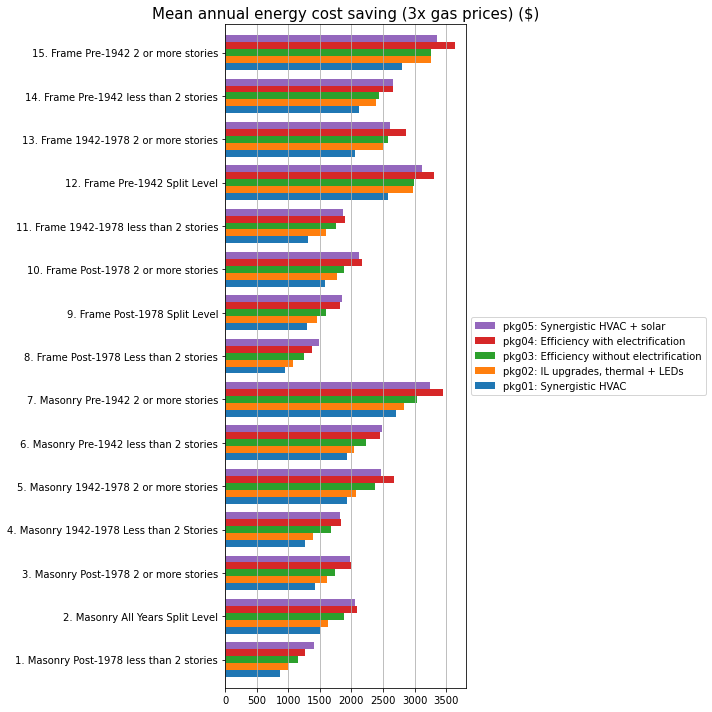

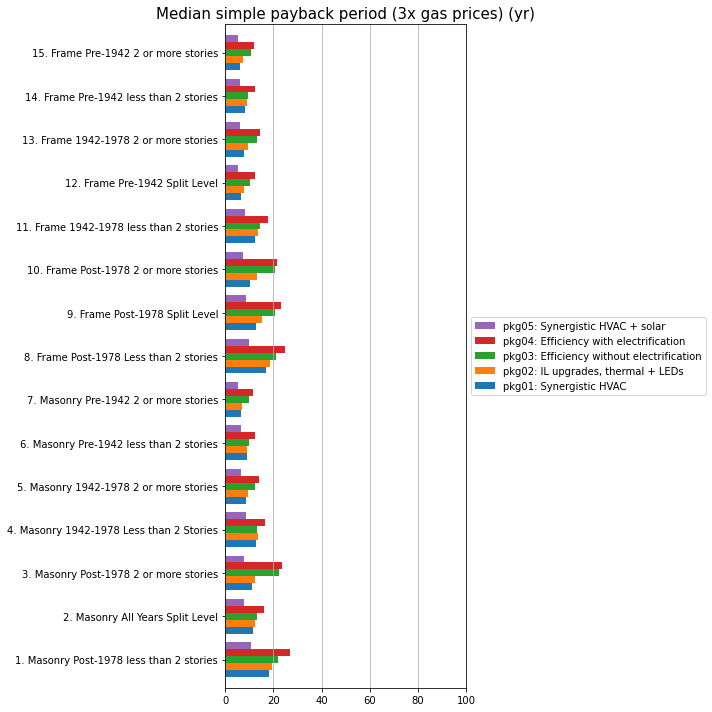

In [34]:
### other metrics to consider:
# monthly utility bills (gas + elec)
# carbon savings (require timeseries results)

zoom_in_plots = False # <-------

zoom_in_xlimits = {
    'mean_pct_delta_gas_eui': [None, None],
    'mean_pct_delta_elec_eui': [None, None],
    'mean_pct_delta_site_eui': [-25, None],
    'mean_upgrade_cost': [None, 10000],
    'mean_ann_kbtu_saved_per_dollar': [None, 500],
    'mean_ann_energy_cost_saving': [None, 2000],
    'median_simple_payback': [-70, 70],
    'mean_ann_metric_ton_co2e_saving': [None, 20],
}

# create subfolder for plots:
plot_path1 = os.path.join(plot_path, 'mean_values_by_prototype')
if not os.path.exists(plot_path1):
    os.mkdir(plot_path1)
print(f'plot dir: {plot_path1}\n')

title_ext = '' if fn_ext == '' else f' ({fn_ext.replace("_"," ").lstrip()})'

if NG_rate_multiplier == 1:
    para_labels = {
        'mean_pct_delta_gas_eui': 'Mean percent change from baseline in gas use intensity (therm/sqft)',
        'mean_pct_delta_elec_eui': 'Mean percent change from baseline in electricity use intensity (kWh/sqft)',
        'mean_pct_delta_site_eui': 'Mean percent change from baseline in site energy use intensity (kBtu/sqft)',
        'mean_upgrade_cost': 'Mean upgrade capital cost ($)',
        'mean_ann_kbtu_saved_per_dollar': 'Mean annual site energy saving per upgrade cost (kBtu/$)',
        'mean_ann_energy_cost_saving': f'Mean annual energy cost saving{title_ext} ($)',
        'median_simple_payback': f'Median simple payback period{title_ext} (yr)',
        'mean_ann_metric_ton_co2e_saving': f'Mean annual carbon emission saving (metric ton CO₂e)',
    }
else:
    para_labels = {
        'mean_ann_energy_cost_saving': f'Mean annual energy cost saving{title_ext} ($)',
        'median_simple_payback': f'Median simple payback period{title_ext} (yr)',
    }

    
for i, para_to_plot in enumerate(para_labels.keys(),1):
    
    zoom_ext = ''
    if zoom_in_plots:
        if len(list(x for x in zoom_in_xlimits[para_to_plot] if x is not None))>0:
            zoom_ext = '_zoomed'
    
    print(f'>> {i}. plotting {para_to_plot}{fn_ext}{zoom_ext}...')
    para_label = para_labels[para_to_plot]

    idx = groups2.loc[:,(('Baseline'),('HousingGroupNo'))].astype(str) +'. '+\
          groups2.loc[:,(('Baseline'),('HousingGroupName'))]
    UPi = groups2.set_index(idx)[para_to_plot]
    xmin = UPi.replace([np.inf, -np.inf], np.nan).min().min()
    xmax = UPi.replace([np.inf, -np.inf], np.nan).max().max()

    fig, ax = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True, figsize=(10, 10))

    ### Group 1: Intensive, fuel-agnostic upgrades (upg01-upg21)
    # Group 1A: (upg01-upg10) N=10
    UPi.plot(kind='barh', width=0.8, ax=ax)
    ax.xaxis.grid(True)
    if (para_to_plot[-3:]=='eui') & (xmin < -50):
        ax.axvline(x=-50, linestyle='--', color='darkred')
    ax.set_title(para_label, fontsize=15, y=1)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], ncol=1, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='medium')
    ax.margins(y=0)
    
    if zoom_in_plots:
        [xmin, xmax] = zoom_in_xlimits[para_to_plot]
        if xmin is not None:
            ax.set_xlim(left = xmin)
        if xmax is not None:
            ax.set_xlim(right=xmax)
            
    if para_to_plot == 'median_simple_payback':
        ax.set_xlim(0,100)
    
    plt.tight_layout()
    
    filename = f'{iter_path}-comparison_{para_to_plot}{fn_ext}.pdf'
    fig.savefig(os.path.join(plot_path1, filename),
                bbox_inches='tight')


#### 2.3.2. plot mean values for Chicago avg per SFD

In [35]:
Wtchicago = groups2.loc[:,[('Baseline', 'HousingGroupName'),('Baseline', 'Chicago Prevalence')]
                       ]['Baseline'].set_index('HousingGroupName')

## add 'Chicago avg' and 'Chicago total'
groups_avg = groups2.set_index(('Baseline', 'HousingGroupName')).drop('Baseline', level=0, axis=1)
groups_avg.index.name = groups_avg.index.name[1]
groups_avg = groups_avg.stack(level=0).stack().unstack(level=0)
groups_avg['Chicago avg'] = np.where(np.isnan(groups_avg),0,groups_avg).dot(
    np.where(np.isnan(Wtchicago),0,Wtchicago)) # np.dot() ignoring nan

## add upgrade names
upgrade_name_map = summary_upgrades[['upgrade_no','upgrade_name']]
upgrade_name_map.loc[:,'upgrade'] = upgrade_name_map['upgrade_no'].astype(int)
# upgrade_name_map.loc[:,'upgrade'] = 'upg' + \
#     upgrade_name_map['upgrade_no'].astype(int).astype(str).str.rjust(2,'0')
upgrade_name_map = upgrade_name_map.set_index('upgrade')['upgrade_name']

groups_avg = groups_avg.reset_index().rename({'level_0':'metrics','level_1':'upgrade_no'}, axis=1)
groups_avg['upgrade_no'] = groups_avg['upgrade_no'].str[3:5].astype(int)
groups_avg['upgrade_name'] = groups_avg['upgrade_no'].map(upgrade_name_map)
groups_avg = groups_avg.set_index(['metrics','upgrade_no','upgrade_name']).sort_index().reset_index()

### save a copy
groups_avg.to_csv(os.path.join(result_path,
                               'processed results',
                               f'upgrades_prototype_chicago_avg_results{fn_ext}.csv'),
                  index=True)
groups_avg

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1675: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


HousingGroupName,metrics,upgrade_no,upgrade_name,Frame 1942-1978 2 or more stories,Frame 1942-1978 less than 2 stories,Frame Post-1978 2 or more stories,Frame Post-1978 Less than 2 stories,Frame Post-1978 Split Level,Frame Pre-1942 2 or more stories,Frame Pre-1942 Split Level,Frame Pre-1942 less than 2 stories,Masonry 1942-1978 2 or more stories,Masonry 1942-1978 Less than 2 Stories,Masonry All Years Split Level,Masonry Post-1978 2 or more stories,Masonry Post-1978 less than 2 stories,Masonry Pre-1942 2 or more stories,Masonry Pre-1942 less than 2 stories,Chicago avg
0,mean_ann_energy_cost_saving,1,Synergistic HVAC,2061.850,1316.120,1580.840,946.610,1300.220,2805.380,2579.500,2120.990,1922.850,1271.390,1503.900,1428.500,870.020,2702.660,1934.150,1884.702370
1,mean_ann_energy_cost_saving,2,"IL upgrades, thermal + LEDs",2496.800,1597.050,1763.060,1075.980,1459.050,3259.970,2969.740,2381.420,2065.520,1395.360,1631.420,1604.990,1000.620,2830.100,2034.380,2084.334492
2,mean_ann_energy_cost_saving,3,Efficiency without electrification,2571.170,1761.210,1888.810,1240.660,1602.030,3261.460,2991.160,2443.260,2374.500,1677.350,1883.400,1736.420,1157.640,3036.160,2230.270,2233.707035
3,mean_ann_energy_cost_saving,4,Efficiency with electrification,2867.940,1901.520,2166.980,1370.910,1814.750,3632.230,3311.950,2662.740,2670.650,1828.290,2082.080,1993.620,1265.720,3455.510,2447.350,2500.750388
4,mean_ann_energy_cost_saving,5,Synergistic HVAC + solar,2606.290,1860.550,2125.270,1491.040,1844.650,3349.810,3123.940,2665.420,2467.280,1815.820,2048.330,1972.930,1414.450,3247.100,2478.580,2429.135053
5,mean_ann_kbtu_saved_per_dollar,1,Synergistic HVAC,6.290,5.200,6.150,5.020,5.650,5.620,5.280,4.600,6.040,5.070,5.250,6.500,5.050,5.570,4.620,5.377167
6,mean_ann_kbtu_saved_per_dollar,2,"IL upgrades, thermal + LEDs",3.710,3.430,4.230,3.710,4.000,3.380,3.340,3.260,4.850,4.080,4.250,4.830,3.980,4.740,4.080,4.008629
7,mean_ann_kbtu_saved_per_dollar,3,Efficiency without electrification,3.120,3.040,2.960,3.030,2.990,3.010,3.120,3.350,3.540,3.470,3.470,3.000,3.170,3.690,3.800,3.267247
8,mean_ann_kbtu_saved_per_dollar,4,Efficiency with electrification,1.550,1.570,1.580,1.620,1.600,1.380,1.430,1.520,1.720,1.700,1.690,1.630,1.700,1.600,1.670,1.577948
9,mean_ann_kbtu_saved_per_dollar,5,Synergistic HVAC + solar,5.120,3.990,5.010,3.800,4.470,4.530,4.180,3.460,4.890,3.860,4.060,5.310,3.820,4.490,3.480,4.228428


plot dir: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_01/processed results/plots/mean_values_chicago_avg

Plotting Chicago avg: mean_ann_energy_cost_saving (3x gas prices)...
    - Group1
Plotting Chicago avg: median_simple_payback (3x gas prices)...
    - Group1


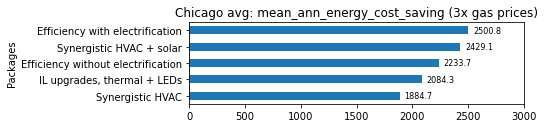

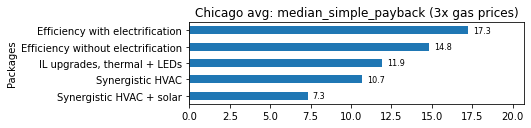

In [36]:
para_to_plot = 'Chicago avg' # <------

upgrade_sets = {
    'Packages': range(1, N_upgrades+1),
}
upgrade_set_colors = {
    'Packages': 'tab:blue',
}

# create subfolder for plots:
plot_path2 = os.path.join(plot_path, 'mean_values_chicago_avg')
if not os.path.exists(plot_path2):
    os.mkdir(plot_path2)
print(f'plot dir: {plot_path2}\n')

if NG_rate_multiplier == 1: 
    metrics_to_plot = groups_avg['metrics'].unique()
else:
    metrics_to_plot = ['mean_ann_energy_cost_saving', 'median_simple_payback']
    
for metric in metrics_to_plot:
    title_ext = '' if fn_ext == '' else f' ({fn_ext.replace("_"," ").lstrip()})'
    title = f'{para_to_plot}: {metric}{title_ext}'
    print(f'Plotting {title}...')
    
    for n, up in enumerate(upgrade_sets.keys(),1):
        print(f'    - Group{n}')
        
        groupi = groups_avg[(groups_avg['metrics']==metric) & 
                              (groups_avg['upgrade_no'].isin(upgrade_sets[up]))][[
            'upgrade_name',para_to_plot]].set_index('upgrade_name').sort_values(by=para_to_plot)
        groupi.index.name = up
        
        ht = len(groupi)
        fig, ax = plt.subplots(figsize=(6, 0.3*ht))
        groupi.plot.barh(color=upgrade_set_colors[up], legend=False, title=title, ax=ax)
        
        # For each bar: Place a label ############################
        rects = ax.patches
        for rect in rects:
            # Get X and Y placement of label from rect.
            x_value = rect.get_width()
            y_value = rect.get_y() + rect.get_height() / 2

            # Number of points between bar and label. Change to your liking.
            space = 5
            # Vertical alignment for positive values
            ha = 'left'

            # If value of bar is negative: Place label left of bar
            if x_value < 0:
                # Invert space to place label to the left
                space *= -1
                # Horizontally align label at right
                ha = 'right'

            # Use X value as label and format number with one decimal place
            label = "{:.1f}".format(x_value)

            # Create annotation
            plt.annotate(
                label,                      # Use `label` as label
                (x_value, y_value),         # Place label at end of the bar
                xytext=(space, 0),          # Horizontally shift label by `space`
                textcoords="offset points", # Interpret `xytext` as offset in points
                va='center',                # Vertically center label
                ha=ha,                      # Horizontally align label differently for
                fontsize=8)                 # positive and negative values. 
            
        ax.margins(x=0.2)    
        ax.axvline(x=0, linestyle='-', color='gray')
        if (metric[-3:]=='eui') & (ax.get_xlim()[0] < -50):
            ax.axvline(x=-50, linestyle='--', color='darkred')
        
        filename = f'upgrades_{iteration}-{para_to_plot}_{metric}{fn_ext}.pdf'
        fig.savefig(os.path.join(plot_path2, filename),
                    bbox_inches='tight')
        

#### 2.3.3. plot mean values for Chicago total stock 
Run cell below to load df for plots

In [22]:
load_df_for_plot_below_from_file = False # <-----

if load_df_for_plot_below_from_file:
    NG_rate_multiplier = 1 # 1 or 3 <----- This controls what to plot in both '2.3.1.' and '2.3.2.' plots
 
    if NG_rate_multiplier > 1:
        fn_ext = f'_{NG_rate_multiplier}x_gas_prices' # file name extension to add to relevant results
    else:
        fn_ext = ''
    
    groups_total = pd.read_csv(os.path.join(result_path,'processed results',f'upgrades_prototype_chicago_total{fn_ext}.csv'),
                         header=[0])
    
    print(f'"groups_total{fn_ext}" df loaded from file.')
    display(groups_total)
    

plot dir: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_01/processed results/plots/sum_values_chicago_total

Plotting Chicago total ann_gas_cost_saving (3x gas prices)...
    - Group1


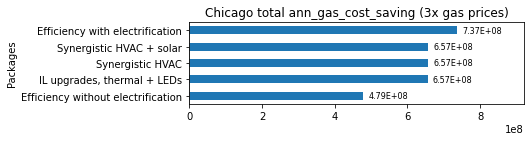

In [37]:
para_to_plot = 'Chicago total' # <------

upgrade_sets = {
    'Packages': range(1, N_upgrades+1),
}
upgrade_set_colors = {
    'Packages': 'tab:blue',
}

# create subfolder for plots:
plot_path3 = os.path.join(plot_path, 'sum_values_chicago_total')
if not os.path.exists(plot_path3):
    os.mkdir(plot_path3)
print(f'plot dir: {plot_path3}\n')

if NG_rate_multiplier == 1: 
    metrics_to_plot = groups_total['metrics'].unique()
else:
    metrics_to_plot = ['mean_ann_gas_cost_saving']
    
for metric in metrics_to_plot:
    title_ext = '' if fn_ext == '' else f' ({fn_ext.replace("_"," ").lstrip()})'
    title = f'{para_to_plot} {metric[5:]}{title_ext}'
    print(f'Plotting {title}...')
    
    for n, up in enumerate(upgrade_sets.keys(),1):
        print(f'    - Group{n}')
        
        groupi = groups_total[(groups_total['metrics']==metric) & 
                              (groups_total['upgrade_no'].isin(upgrade_sets[up]))][[
            'upgrade_name',para_to_plot]].set_index('upgrade_name').sort_values(by=para_to_plot)
        groupi.index.name = up
        
        ht = len(groupi)
        fig, ax = plt.subplots(figsize=(6, 0.3*ht))
        groupi.plot.barh(color=upgrade_set_colors[up], legend=False, title=title, ax=ax)
        
        # For each bar: Place a label ############################
        rects = ax.patches
        for rect in rects:
            # Get X and Y placement of label from rect.
            x_value = rect.get_width()
            y_value = rect.get_y() + rect.get_height() / 2

            # Number of points between bar and label. Change to your liking.
            space = 5
            # Vertical alignment for positive values
            ha = 'left'

            # If value of bar is negative: Place label left of bar
            if x_value < 0:
                # Invert space to place label to the left
                space *= -1
                # Horizontally align label at right
                ha = 'right'

            # Use X value as label and format number with one decimal place
            label = "{:.2E}".format(x_value)

            # Create annotation
            plt.annotate(
                label,                      # Use `label` as label
                (x_value, y_value),         # Place label at end of the bar
                xytext=(space, 0),          # Horizontally shift label by `space`
                textcoords="offset points", # Interpret `xytext` as offset in points
                va='center',                # Vertically center label
                ha=ha,                      # Horizontally align label differently for
                fontsize=8)                 # positive and negative values.                      
                                            
        ax.margins(x=0.25)
        ax.axvline(x=0, linestyle='-', color='gray')
        
        filename = f'upgrades_{iteration}-{para_to_plot}_{metric[5:]}{fn_ext}.pdf'
        fig.savefig(os.path.join(plot_path3, filename),
                    bbox_inches='tight')

#### 2.3.4. plot metrics distribution
Run cell below to load df for plots

In [28]:
load_df_for_plot_below_from_file = False # <-----

if load_df_for_plot_below_from_file:
    NG_rate_multiplier = 1 # 1 or 3 <----- This controls what to plot in both '2.3.1.' and '2.3.2.' plots
 
    if NG_rate_multiplier > 1:
        fn_ext = f'_{NG_rate_multiplier}x_gas_prices' # file name extension to add to relevant results
    else:
        fn_ext = ''

    all_proto_upgrades = pd.read_csv(os.path.join(result_path, 'processed results', 'all_upgrades_by_prototype_combined.csv'))
    
    print(f'"all_proto_upgrades{fn_ext}" df loaded from file.')
    N_upgrades = all_proto_upgrades['package_no'].unique().max()
    print(f'   total number of packages: {N_upgrades}')
    
    display(all_proto_upgrades)


"all_proto_upgrades" df loaded from file.
   total number of packages: 5


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,simulation_output_report.duct_surface_area_ft_2,...,pct_delta_gas_eui,pct_delta_elec_eui,pct_delta_site_eui,ann_kbtu_saved_per_dollar,ann_energy_cost_saving,simple_payback,ann_metric_ton_co2e_saving,package_no,HousingGroupNo,HousingGroupName
0,69,133,2021-01-01 11:55:19,2021-01-01 11:58:35,Success,True,Synergistic HVAC,True,20.0,1221.37,...,-71.159028,53.424550,-47.468256,3.454277,468.143398,97.935975,1.755627,1,1,Masonry Post-1978 less than 2 stories
1,74,83,2021-01-01 06:22:52,2021-01-01 06:26:01,Success,True,Synergistic HVAC,True,20.0,234.21,...,-59.953379,47.709967,-33.142288,2.725408,57.338240,378.429127,-0.450934,1,1,Masonry Post-1978 less than 2 stories
2,104,36,2021-01-01 06:07:50,2021-01-01 06:10:54,Success,True,Synergistic HVAC,True,20.0,1221.37,...,-85.351836,72.179853,-53.350088,2.364455,157.158413,245.181783,0.065286,1,1,Masonry Post-1978 less than 2 stories
3,130,110,2021-01-01 12:27:34,2021-01-01 12:30:42,Success,True,Synergistic HVAC,True,20.0,805.12,...,-85.813247,34.738253,-53.139756,1.652336,337.562741,113.268899,1.384117,1,1,Masonry Post-1978 less than 2 stories
4,150,1,2021-01-01 03:31:50,2021-01-01 03:35:10,Success,True,Synergistic HVAC,True,20.0,805.12,...,-72.221492,83.255739,-41.135877,1.826454,-30.747837,-873.163203,-0.829935,1,1,Masonry Post-1978 less than 2 stories
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146759,16750,22,2021-01-01 06:39:18,2021-01-01 06:42:00,Success,True,Synergistic HVAC + solar,True,20.0,390.40,...,-85.712520,33.039579,-75.809854,0.927064,1101.454078,57.556335,8.523184,5,15,Frame Pre-1942 2 or more stories
146760,16758,209,2021-01-01 10:08:28,2021-01-01 10:11:21,Success,True,Synergistic HVAC + solar,True,20.0,852.16,...,-90.642280,64.773507,-66.551509,1.561441,551.047268,85.789483,3.577039,5,15,Frame Pre-1942 2 or more stories
146761,16759,99,2021-01-01 06:29:49,2021-01-01 06:33:04,Success,True,Synergistic HVAC + solar,True,20.0,283.20,...,-86.619449,46.202768,-70.891235,0.863496,579.281661,89.940634,4.213846,5,15,Frame Pre-1942 2 or more stories
146762,16769,190,2021-01-01 09:29:10,2021-01-01 09:32:37,Success,True,Synergistic HVAC + solar,True,20.0,540.80,...,-83.889566,5.626264,-65.343089,1.524440,1361.258655,45.719438,8.911148,5,15,Frame Pre-1942 2 or more stories


plot dir: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_packages_01/processed results/plots/distribution_by_prototype

>> 1. plotting ann_energy_cost_saving_3x_gas_prices...
>> 2. plotting simple_payback_3x_gas_prices...


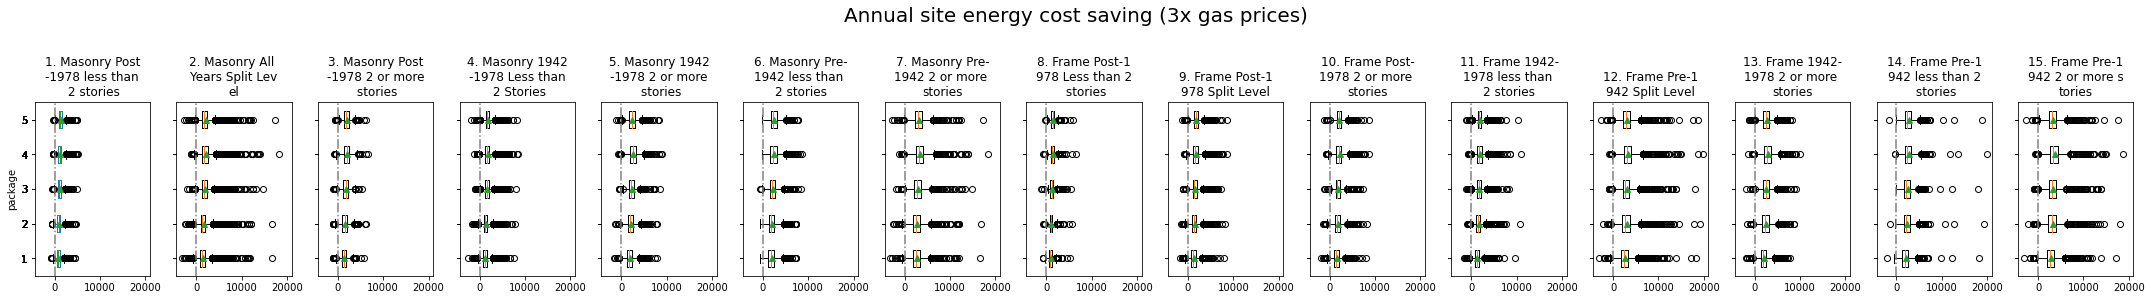

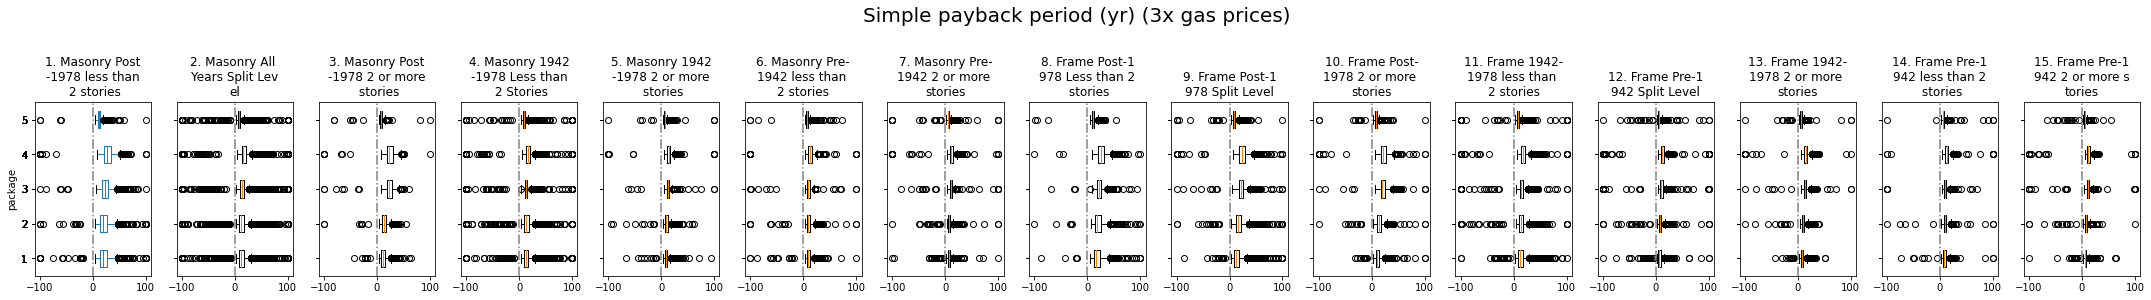

In [38]:
### other metrics to consider:
# monthly utility bills (gas + elec)
# carbon savings (require timeseries results)

# create subfolder for plots:
plot_path4 = os.path.join(plot_path, 'distribution_by_prototype')
if not os.path.exists(plot_path4):
    os.mkdir(plot_path4)
print(f'plot dir: {plot_path4}\n')

title_ext = '' if fn_ext == '' else f' ({fn_ext.replace("_"," ").lstrip()})'

## modifying payback periods, cap either ends at [100,-100] 
all_proto_upgrades.loc[(all_proto_upgrades[all_proto_upgrades['simple_payback']>100]).index,
                       'simple_payback'] = 100
all_proto_upgrades.loc[(all_proto_upgrades[all_proto_upgrades['simple_payback']<-100]).index,
                       'simple_payback'] = -100

if NG_rate_multiplier == 1:
    para_labels = {
        'pct_delta_gas_eui': 'Percent change from baseline in gas use intensity (therm/sqft)',
        'pct_delta_elec_eui': 'Percent change from baseline in electricity use intensity (kWh/sqft)',
        'pct_delta_site_eui': 'Percent change from baseline in site energy use intensity (kBtu/sqft)',
        'upgrade_cost': 'Upgrade capital cost ($)',
        'ann_kbtu_saved_per_dollar': 'Annual site energy saving per upgrade cost (kBtu/$)',
        'ann_energy_cost_saving': f'Annual site energy cost saving{title_ext}',
        'simple_payback': f'Simple payback period (yr){title_ext}',
        'ann_metric_ton_co2e_saving': f'Annual carbon emission saving (metric ton CO₂e)',
    }
else:
    para_labels = {
        'ann_energy_cost_saving': f'Annual site energy cost saving{title_ext}',
        'simple_payback': f'Simple payback period (yr){title_ext}',
    }

cols_to_match = list(f'pkg{n:02d}' for n in range(1,N_upgrades+1))

for i, para_to_plot in enumerate(para_labels.keys(),1):
    
    print(f'>> {i}. plotting {para_to_plot}{fn_ext}...')
    xmin = all_proto_upgrades[para_to_plot].min(); xmax = all_proto_upgrades[para_to_plot].max()
    
    fig, axes = plt.subplots(ncols=15, nrows=1, sharex=True, sharey=True, figsize=(30, 4))
    for h in range(1,16):
        ax = axes[h-1]
        p = all_proto_upgrades.query('HousingGroupNo==@h')[['HousingGroupNo','HousingGroupName',
                                                            'package_no', para_to_plot]]
        lab = f'{p["HousingGroupNo"].iloc[0]}. {p["HousingGroupName"].iloc[0]}'
        lab = '\n'.join([lab[i:i+15] for i in range(0, len(lab), 15)]) # break up long string
        p.loc[:,'package_no'] = 'pkg'+p['package_no'].astype(str).str.zfill(2)
        p = p.sort_values(by='package_no')
        p = p.set_index([p.index, 'package_no'])[
            para_to_plot].unstack(level=-1).dropna(
            axis=0, how='all')
        
        ### show all upgrades
        for col in set(cols_to_match)-set(p.columns):
            p[col] = np.nan
        p = p.sort_index(axis=1).reset_index(drop=True)
    
        if para_to_plot == 'simple_payback':
            showmeans = False
        else:
            showmeans = True
            
        try:
            p.boxplot(ax=ax, vert=False, grid=False, showmeans=showmeans)
        except:
            pass

        ax.set_title(lab)
        if h==1:
            ax.set_ylabel('package')
        ax.axvline(x=0, linestyle='-.', color='gray')
        if (para_to_plot[-3:]=='eui') & (xmin < -50):
            ax.axvline(x=-50, linestyle='--', color='darkred')
        
    para_label = para_labels[para_to_plot]
    fig.suptitle(para_label, fontsize=20, y=1.03)
    plt.tight_layout()
    
    filename = os.path.join(plot_path4, f'{iter_path}-distribution_{para_to_plot}{fn_ext}.pdf')
    fig.savefig(filename, bbox_inches='tight')


### 3. Optional: Useful aggregations for diagnosis

### Add additional metrics to ResStock results

In [69]:
### get sqft distr by building type and vintage
res_sqft_distr = res.groupby(['build_existing_model.geometry_building_type_recs', 'build_existing_model.vintage_acs',
    'build_existing_model.geometry_floor_area'])['building_id'].count().to_frame()

# normalize
res_sqft_distr = res_sqft_distr.groupby(level = [0,1])['building_id'].apply(lambda x: x/x.sum()).unstack(level=2)

# export
res_sqft_distr.to_csv(os.path.join(result_path, 'baseline', 'building_type_vintage_floor_area.csv'), index=True)
print('sqft distr by vintage & bldg type exported')


sqft distr by vintage & bldg type exported


In [73]:
### get foundation type distr by building type, vintage (EE prototype)
print('>> prevalence')
res_found_distr = res[res['build_existing_model.geometry_building_type_recs'] =="Single-Family Detached"].groupby(
    ['build_existing_model.geometry_wall_type', 'vintage_ee', 'stories',
    'build_existing_model.geometry_foundation_type'])['building_id'].count().to_frame()

# normalize
res_found_distr = res_found_distr.groupby(level = [0,1])['building_id'].apply(lambda x: x/x.sum()).unstack(level=-1)
display(res_found_distr)

print('\n>> gas usage')
res_found_gas = res[res['build_existing_model.geometry_building_type_recs'] =="Single-Family Detached"].groupby(
    ['build_existing_model.geometry_wall_type', 'vintage_ee', 'stories',
    'build_existing_model.geometry_foundation_type'])[
    'simulation_output_report.total_site_natural_gas_therm'].mean().to_frame()
res_found_gas.unstack(level=-1)


>> prevalence


build_existing_model.geometry_foundation_type                          Crawl  \
build_existing_model.geometry_wall_type vintage_ee   stories                   
Masonry                                 1: pre-1942  1: <2 stories  0.067395   
                                                     2: 2+ stories  0.085610   
                                        2: 1942-1978 1: <2 stories  0.118911   
                                                     2: 2+ stories  0.013690   
                                        3: post-1978 1: <2 stories  0.102585   
                                                     2: 2+ stories  0.077565   
WoodStud                                1: pre-1942  1: <2 stories  0.050282   
                                                     2: 2+ stories  0.123120   
                                        2: 1942-1978 1: <2 stories  0.106988   
                                                     2: 2+ stories  0.043855   
                                        3: post-1978 1: <2 stories  0.075724   
                                                     2: 2+ stories  0.073497   

build_existing_model.geometry_foundation_type                       Heated Basement  \
build_existing_model.geometry_wall_type vintage_ee   stories                          
Masonry                                 1: pre-1942  1: <2 stories         0.141469   
                                                     2: 2+ stories         0.163327   
                                        2: 1942-1978 1: <2 stories         0.381566   
                                                     2: 2+ stories         0.058580   
                                        3: post-1978 1: <2 stories         0.206005   
                                                     2: 2+ stories         0.156797   
WoodStud                                1: pre-1942  1: <2 stories         0.093985   
                                                     2: 2+ stories         0.163534   
                                        2: 1942-1978 1: <2 stories         0.239759   
                                                     2: 2+ stories         0.089398   
                                        3: post-1978 1: <2 stories         0.154417   
                                                     2: 2+ stories         0.195991   

build_existing_model.geometry_foundation_type                       Pier and Beam  \
build_existing_model.geometry_wall_type vintage_ee   stories                        
Masonry                                 1: pre-1942  1: <2 stories       0.011536   
                                                     2: 2+ stories       0.009107   
                                        2: 1942-1978 1: <2 stories       0.014963   
                                                     2: 2+ stories       0.001273   
                                        3: post-1978 1: <2 stories       0.019183   
                                                     2: 2+ stories       0.011676   
WoodStud                                1: pre-1942  1: <2 stories       0.001410   
                                                     2: 2+ stories       0.003759   
                                        2: 1942-1978 1: <2 stories       0.018795   
                                                     2: 2+ stories       0.008434   
                                        3: post-1978 1: <2 stories       0.005197   
                                                     2: 2+ stories       0.008909   

build_existing_model.geometry_foundation_type                           Slab  \
build_existing_model.geometry_wall_type vintage_ee   stories                   
Masonry                                 1: pre-1942  1: <2 stories  0.034608   
                                                     2: 2+ stories  0.051002   
                                        2: 1942-1978 1: <2 stories  0.178606   
                                                     2: 2+ stories  0


>> gas usage


simulation_output_report.total_site_natural_gas_therm  \
build_existing_model.geometry_foundation_type                                                                      Crawl   
build_existing_model.geometry_wall_type vintage_ee   stories                                                               
Masonry                                 1: pre-1942  1: <2 stories                                        1940.461603      
                                                     2: 2+ stories                                        2458.390036      
                                        2: 1942-1978 1: <2 stories                                        1569.225704      
                                                     2: 2+ stories                                        2085.599435      
                                        3: post-1978 1: <2 stories                                         997.958444      
                                                     2: 2+ stories                                        1465.916083      
WoodStud                                1: pre-1942  1: <2 stories                                        1832.262789      
                                                     2: 2+ stories                                        2339.902964      
                                        2: 1942-1978 1: <2 stories                                        1563.475069      
                                                     2: 2+ stories                                        2059.848575      
                                        3: post-1978 1: <2 stories                                        1106.906242      
                                                     2: 2+ stories                                        1749.793063      

                                                                                    \
build_existing_model.geometry_foundation_type                      Heated Basement   
build_existing_model.geometry_wall_type vintage_ee   stories                         
Masonry                                 1: pre-1942  1: <2 stories      927.833921   
                                                     2: 2+ stories     1610.622552   
                                        2: 1942-1978 1: <2 stories      849.796824   
                                                     2: 2+ stories     1435.606517   
                                        3: post-1978 1: <2 stories      613.756635   
                                                     2: 2+ stories     1130.098897   
WoodStud                                1: pre-1942  1: <2 stories     1073.996908   
                                                     2: 2+ stories     1659.683948   
                                        2: 1942-1978 1: <2 stories      861.448258   
                                                     2: 2+ stories     1541.657212   
                                        3: post-1978 1: <2 stories      661.310294   
                                                     2: 2+ stories     1143.715722   

                                                                                  \
build_existing_model.geometry_foundation_type                      Pier and Beam   
build_existing_model.geometry_wall_type vintage_ee   stories                       
Masonry                                 1: pre-1942  1: <2 stories   1993.172841   
                                                     2: 2+ stories   2648.913123   
                                        2: 1942-1978 1: <2 stories   1795.871929   
                                                     2: 2+ stories   2183.880144   
                                        3: post-1978 1: <2 stories   1517.001083   
                                                     2: 2+ stories   2047.359080   
WoodStud                                1: pre-1942  1: <2 stories   2367.532625   
                                                     2: 2+ stories   2506.8

In [78]:
res[(res['completed_status']=="Success") &
    (res['build_existing_model.geometry_building_type_recs'] == "Single-Family Detached")
   ].groupby(['build_existing_model.vintage', 'build_existing_model.geometry_stories'])[
    'simulation_output_report.total_site_natural_gas_therm','gas_eui', 
    'simulation_output_report.total_site_electricity_kwh', 'elec_eui','sqft'].mean()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


simulation_output_report.total_site_natural_gas_therm  \
build_existing_model.vintage build_existing_model.geometry_stories                                                          
1940s                        1                                                                            1165.567346       
                             2                                                                            1663.586278       
                             3                                                                            2902.876088       
1950s                        1                                                                            1151.998294       
                             2                                                                            1758.102403       
                             3                                                                            2356.456906       
1960s                        1                                                                            1210.069079       
                             2                                                                            1803.041217       
                             3                                                                            2253.285793       
1970s                        1                                                                            1085.069685       
                             2                                                                            1568.397085       
                             3                                                                            1992.237307       
1980s                        1                                                                            1023.246750       
                             2                                                                            1562.276096       
                             3                                                                            2130.240485       
1990s                        1                                                                             959.363511       
                             2                                                                            1459.369301       
                             3                                                                            2122.163827       
2000s                        1                                                                             744.748035       
                             2                                                                            1074.057426       
                             3                                                                            1340.696042       
2010s                        1                                                                             651.038006       
                             2                                                                            1200.248688       
                             3                                                                            1918.241436       
<1940                        1                                                                            1480.098034       
                             2                                                                            2005.382117       
                             3                                                                            2718.633120       

                                                                     gas_eui  \
build_existing_model.vintage build_existing_model.geometry_stories             
1940s                        1                                      0.785852   
                             2                                      0.897455   
                             3                                      1.158714   
1950s                        1            